In [ ]:
IN_COLAB = True

output_dir = 'results/'

try:
  import google.colab
  # Using Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Dataset download and extraction
  !unzip -qq drive/MyDrive/cern/data/rich.zip

  # Model checkpoint download and extraction
  !unzip -qq drive/MyDrive/cern/data/checkpoints_dropout_0.01.zip

  # Model embeddings download and extraction
  !unzip -qq drive/MyDrive/cern/data/embeddings.zip

  # Results folder creation
  !mkdir /content/drive/MyDrive/cern/data/results

  output_dir = f'/content/drive/MyDrive/cern/data/{output_dir}'

except:
  IN_COLAB = False

print(f'IN_COLAB: {IN_COLAB}')

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/cern/data/results’: File exists
IN_COLAB: True


In [ ]:
!git clone https://github.com/evillag/uncertainty_gan.git
!mv uncertainty_gan/mcd .
!mv uncertainty_gan/feature_densities .
!mv uncertainty_gan/test_bench .
%rm -rf uncertainty_gan/

!git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
!mv lhcb-rich-gan-uncertainty/experiments .
!mv lhcb-rich-gan-uncertainty/src .
%rm -rf lhcb-rich-gan-uncertainty/
%rm -rf sample_data/
!pip install tf_keras

Cloning into 'uncertainty_gan'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 210 (delta 31), reused 4 (delta 3), pack-reused 147
Receiving objects: 100% (210/210), 31.82 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (107/107), done.
Cloning into 'lhcb-rich-gan-uncertainty'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210 (from 1)
Receiving objects: 100% (210/210), 2.94 MiB | 22.82 MiB/s, done.
Resolving deltas: 100% (94/94), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel

# Test Bench for the Monte Carlo Dropout and Feature Density methods

1. Select sample data
2. Create a model
3. Generate a single target with single inference mode
4. Estimate MCD uncertainty
5. Estimate FD uncertainty

In [ ]:
# Parameters
PARTICLE = 'pion'
CHECKPOINT_DP = 0.01
DROPOUT_TYPE = 'bernoulli_structured'
CHECKPOINT_BASE = 'checkpoints/'
DATA_DIR = 'rich/'
SUB_SAMPLE_SIZE = 100000
DLL_COLUMNS = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

# MCD parameters
MCD_ENSEMBLE_SIZE = 300

# FD parameters
embeddings_dir = f'embeddings/'

# Load results (Optional)

Uncomment to load previous execution results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_dir = f'/content/drive/MyDrive/cern/data/results/'

x_sample = np.load(output_dir + f'{PARTICLE}_x_sample.npy')
y_sample = np.load(output_dir + f'{PARTICLE}_y_sample.npy')
t_generated = np.load(output_dir + f'{PARTICLE}_t_generated.npy')

mcd_uncertainty = np.load(output_dir + f'{PARTICLE}_mcd_uncertainty.npy')
fd_uncertainty_normalized = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy')
#fd_uncertainty_integration = np.load(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy')

# Load data and Sample selection

In [ ]:
dataset = load_particle_datasets(PARTICLE, DATA_DIR)

Reading and concatenating datasets:
	rich/pion_-_up_2016_.csv
	rich/pion2_-_down_2016_.csv
	rich/pion2_+_up_2016_.csv
	rich/pion_-_down_2016_.csv
	rich/pion2_+_down_2016_.csv
	rich/pion_+_down_2016_.csv
	rich/pion_+_up_2016_.csv
	rich/pion2_-_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.311807870864868
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(948571, 3)
targets_train shape	(948571, 5)
feats_val shape  	(525562, 3)
targets_val shape	(525562, 5)



In [ ]:
# Draw a sample of the datasets
x_sample, y_sample = subsample_dataset(dataset['feats_val'], dataset['targets_val'], SUB_SAMPLE_SIZE / dataset['feats_val'].shape[0])
x_sample.shape, y_sample.shape

(TensorShape([100000, 3]), TensorShape([100000, 5]))

# Model creation

In [ ]:
!pip uninstall -y tensorflow

!pip install tensorflow==2.10.1

!pip install tensorflow-addons

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 51.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninst

^C


In [ ]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()

Generating model for pion with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4

Generator:

Model: "virtual_ensemble_model"
________________________________________________________________________________________________
 Layer (type)                              Output Shape                          Param #        
 Inputs (InputLayer)                       [(None, 3)]                           0              
                                                                                                
 NoiseInjection (NoiseInjection)           (None, 67)                            0              
                                                                                                
 Layer_0/Dense (Dense)                     (None, 128)                           8704           
                                                                                                
 Layer_0/LeakyReLU (LeakyReLU)             (None, 128)                           0   

## Single model prediction

In [ ]:
generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

3125/3125 [==============================] - 16s 4ms/step


(100000, 5)

In [ ]:
# Save real and generated targets
np.save(output_dir + f'{PARTICLE}_x_real.npy', x_sample)
np.save(output_dir + f'{PARTICLE}_y_real.npy', y_sample)
np.save(output_dir + f'{PARTICLE}_t_generated.npy', t_generated)

# Noise-Free Model

In [ ]:
ruta_drive = '/content/drive/MyDrive/fcn_gen.py'
ruta_colab = '/content/src/models/gans/generators'

!cp {ruta_drive} {ruta_colab}

In [ ]:
import importlib

from test_bench import get_checkpoint_name, load_particle_datasets, subsample_dataset
from test_bench.model import MonteCarloDropoutModel

import src.models.gans.generators.fcn_gen
import test_bench
import test_bench.model

importlib.reload(test_bench)
importlib.reload(test_bench.model)
importlib.reload(src.models.gans.generators.fcn_gen)

<module 'src.models.gans.generators.fcn_gen' from '/content/src/models/gans/generators/fcn_gen.py'>

In [ ]:
model = MonteCarloDropoutModel(
    PARTICLE,
    dropout_rate=CHECKPOINT_DP,
    checkpoint_dir=CHECKPOINT_BASE + get_checkpoint_name(PARTICLE, CHECKPOINT_DP, DROPOUT_TYPE),
    debug=True
)
generator = model.get_generator()


generator.single_model_inference_mode()
t_generated = generator.predict(x_sample)
t_generated.shape

Generating model for pion with a dropout rate of 0.01
Layer 0


ValueError: Argument `name` must be a string and cannot contain character `/`. Received: name=Layer_0/Dense (of type <class 'str'>)

### Plotting functions

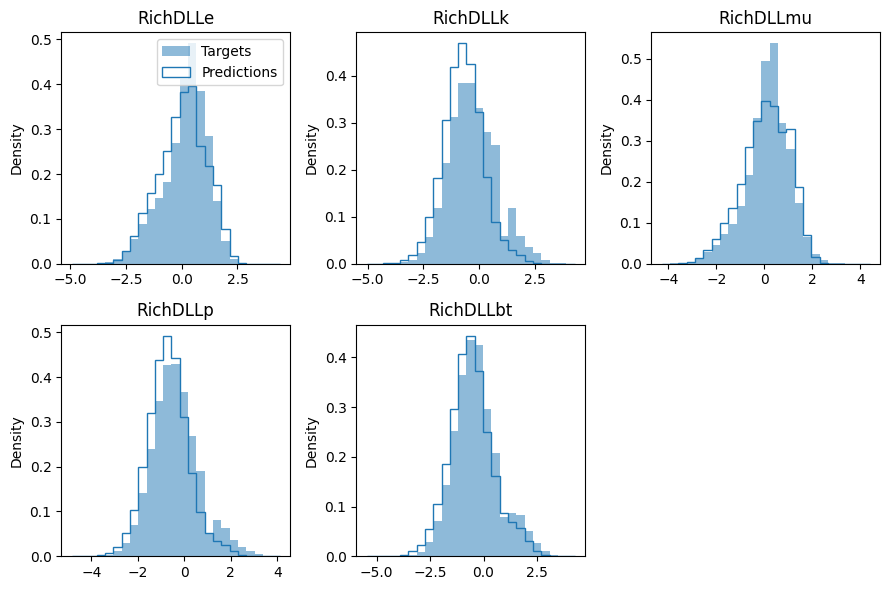

In [ ]:
def plot_target_histrogams(real_targets, generated_targets, dll_columns=DLL_COLUMNS):
  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    particle_targets = np.array(real_targets[:, i])
    particle_predictions = np.array(generated_targets[:, i])

    mins = particle_targets.min(), particle_predictions.min()
    maxs = particle_targets.max(), particle_predictions.max()

    hist_range = min(mins), max(maxs)

    ax.set_title(dll_columns[i])
    ax.hist(particle_targets, 25, hist_range, True, alpha=.5, label='Targets')
    ax.hist(particle_predictions, 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')
    ax.set_ylabel('Density')

  axes[0, 0].legend()
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

plot_target_histrogams(y_sample, t_generated)

The problem with `estimate_distances_and_plot_uncertainty_bins` is that it splits the data in unbalnced bins, with different sizes, some bins could get up to 30k samples while others get less than 20. Instead binning by quantiles generates a balanced number of observations per bin.

In [ ]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import linregress

def estimate_distances_and_plot_uncertainty_bins(y_real, y_generated, uncertainty_scores, uncertainty_type = None, bin_type = 'linear',
                                                 particle_index = 0, n_rows = 2, n_cols = 5, dll_columns=DLL_COLUMNS):
  n_bins = n_rows * n_cols

  targets = np.array(y_real[:, particle_index])
  predictions = np.array(y_generated[:, particle_index])
  uncertainty_scores = np.array(uncertainty_scores)

  if uncertainty_type == 'MCD':
    uncertainty_scores = uncertainty_scores[:, particle_index]

  if bin_type == 'linear':
    bin_edges = np.linspace(uncertainty_scores.min(), uncertainty_scores.max(), n_bins + 1)
  else: # Quantiles
    bin_edges = np.quantile(uncertainty_scores, np.linspace(0, 1, n_bins + 1))

  # Digitize returns sample indices per bin
  bin_indices = np.digitize(uncertainty_scores, bin_edges)

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

  rounded_bin_edges = np.round(bin_edges, 2)

  js_distances = []

  for i, ax in enumerate(axes.flatten()):
    indices = bin_indices == i + 1

    mins = targets[indices].min(), predictions[indices].min()
    maxs = targets[indices].max(), predictions[indices].max()

    hist_range = min(mins), max(maxs)

    targets_hist = ax.hist(targets[indices], 25, hist_range, True, alpha=.5, label='Targets')[0]
    predictions_hist = ax.hist(
        predictions[indices], 25, hist_range, True, histtype='step', color='tab:blue', label='Predictions')[0]

    ax.set_xlabel(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}', bbox={'facecolor': 'none'})

    js_dist = jensenshannon(predictions_hist, targets_hist)
    js_distances += [js_dist]
    print(f'{rounded_bin_edges[i]} < unc. score < {rounded_bin_edges[i + 1]}: Number of observations: {len(predictions[indices])}')

  plt.suptitle(f'{uncertainty_type} uncertainty score bins for {dll_columns[particle_index]}')
  axes[0, 0].legend()
  plt.tight_layout()
  plt.show()
  print("Jensen–Shannon distances:\n" + ", ".join([str(dist) for dist in js_distances]))

  return bin_edges, js_distances


def plot_distances(bin_ranges, distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  bin_ranges = np.mean([bin_ranges[1:], bin_ranges[:-1]], 0)

  plt.title(f'{uncertainty_type} reliability curve for {dll_columns[particle_index]}')
  plt.gca().set_axisbelow(True)
  plt.grid()
  plt.plot(bin_ranges, distances, '.-')
  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.show()

  print('Correlation coefficient:', linregress(bin_ranges, distances).rvalue)

def plot_all_distances(all_bin_ranges, all_distances, uncertainty_type, dll_columns=DLL_COLUMNS, particle_index = 0):
  plt.title(f'{uncertainty_type} reliability curves')
  plt.gca().set_axisbelow(True)
  plt.grid()

  correlation_coefficient = []
  for i in range(5):
    bin_ranges = np.mean([all_bin_ranges[i][1:], all_bin_ranges[i][:-1]], 0)
    plt.plot(bin_ranges, all_distances[i], '.-', label=dll_columns[i])
    regress = linregress(bin_ranges, all_distances[i])
    correlation_coefficient += [regress.rvalue]
    print(f'Correlation coefficient for {dll_columns[i]}:', regress.rvalue)

  plt.xlabel('Uncertainty score')
  plt.ylabel('Jensen–Shannon distance')
  plt.legend()
  plt.show()
  return correlation_coefficient

## Monte Carlo Dropout method

In [ ]:
from mcd.MCDEvaluator import evaluate_model as mcd_evaluate_model

mcd_uncertainty = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0]
mcd_uncertainty.shape

Generating ensemble(300) predictions


100%|██████████| 300/300 [06:30<00:00,  1.30s/it]


TensorShape([100000, 5])

In [ ]:
# Save MCD uncertainties
#np.save(output_dir + f'{PARTICLE}_mcd_uncertainty.npy', mcd_uncertainty)

### Plot MCD uncertainties

#### Linear bins

0.05 < unc. score < 0.12: Number of observations: 4430
0.12 < unc. score < 0.19: Number of observations: 7484
0.19 < unc. score < 0.26: Number of observations: 8106
0.26 < unc. score < 0.33: Number of observations: 20629
0.33 < unc. score < 0.4: Number of observations: 38297
0.4 < unc. score < 0.47: Number of observations: 17853
0.47 < unc. score < 0.54: Number of observations: 2926
0.54 < unc. score < 0.6: Number of observations: 246
0.6 < unc. score < 0.67: Number of observations: 26
0.67 < unc. score < 0.74: Number of observations: 2


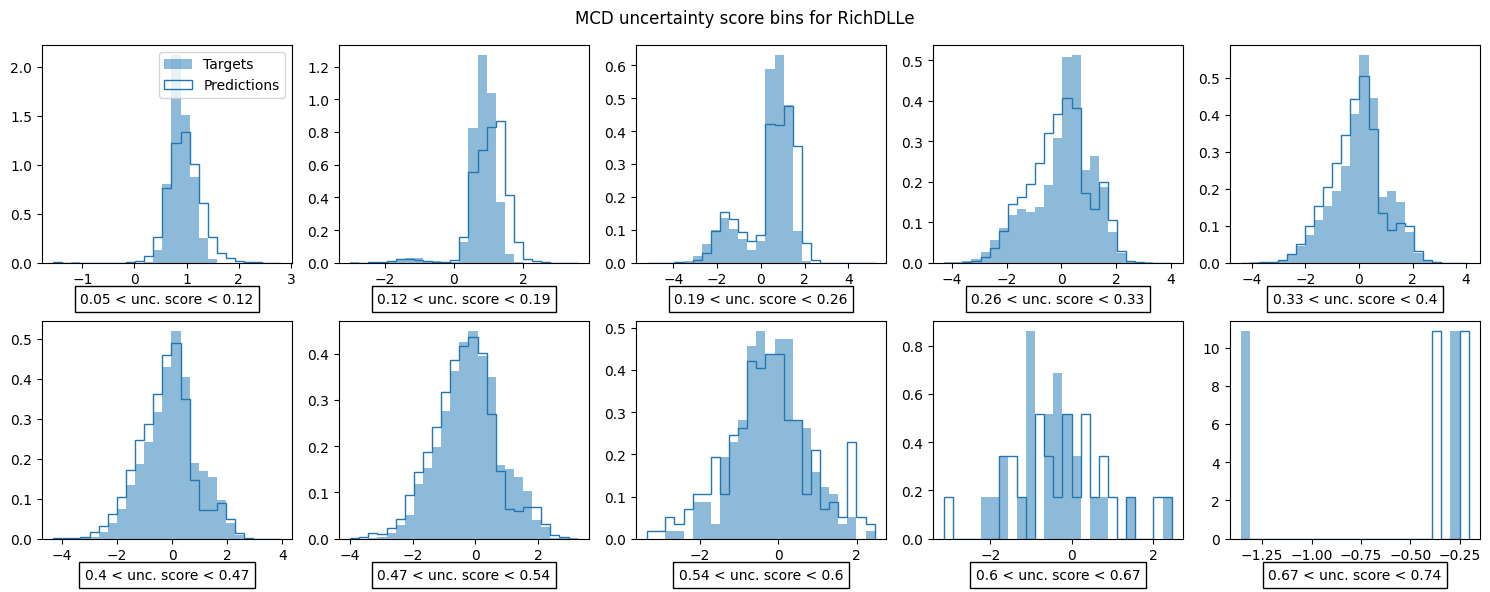

Jensen–Shannon distances:
0.20720840985764472, 0.2556827446660941, 0.18144227538712435, 0.12652145688508104, 0.10049833919999682, 0.10594112066114894, 0.10500883572977694, 0.19799217969237048, 0.5166617679120005, 0.8325546111576977
0.0 < unc. score < 0.09: Number of observations: 260
0.09 < unc. score < 0.18: Number of observations: 284
0.18 < unc. score < 0.27: Number of observations: 9165
0.27 < unc. score < 0.36: Number of observations: 25468
0.36 < unc. score < 0.45: Number of observations: 32227
0.45 < unc. score < 0.55: Number of observations: 22678
0.55 < unc. score < 0.64: Number of observations: 7780
0.64 < unc. score < 0.73: Number of observations: 1768
0.73 < unc. score < 0.82: Number of observations: 320
0.82 < unc. score < 0.91: Number of observations: 49


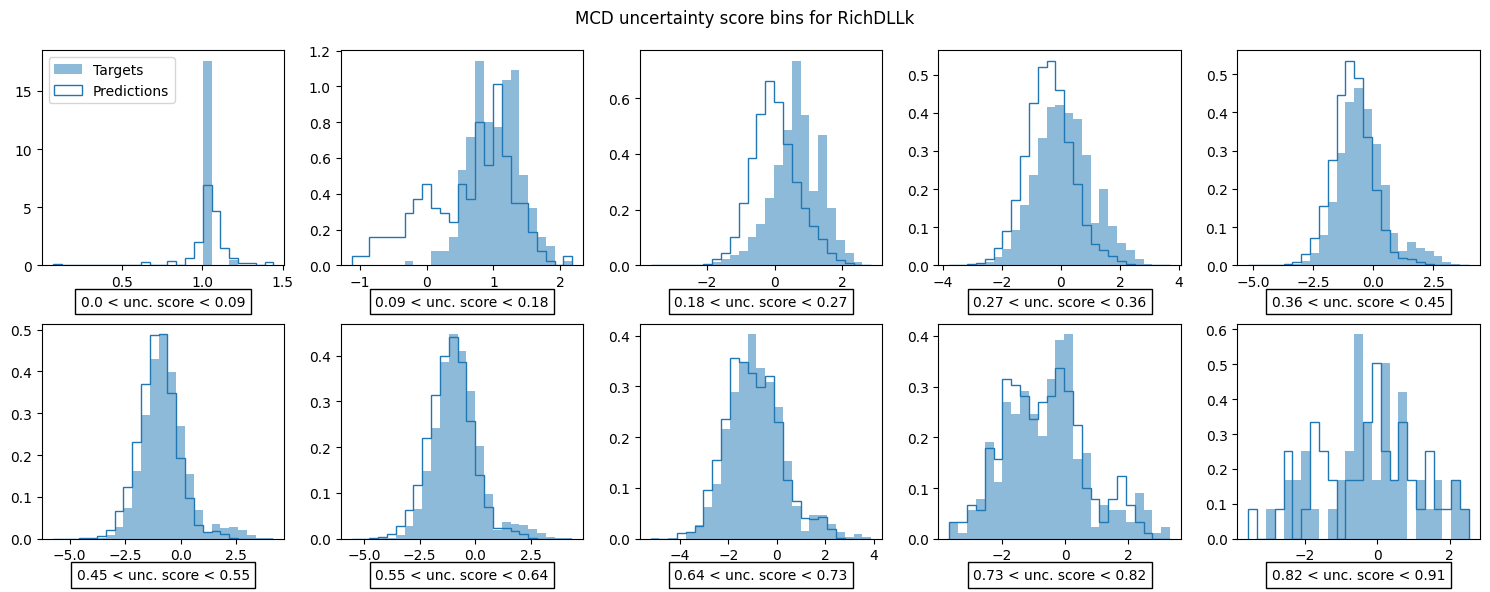

Jensen–Shannon distances:
0.5128478028130239, 0.34795724517770815, 0.33233636082859813, 0.21815150655139606, 0.1844533926056468, 0.1368042197317448, 0.127077930032219, 0.09910859519601588, 0.14169621552981476, 0.3888105556347138
0.01 < unc. score < 0.11: Number of observations: 9835
0.11 < unc. score < 0.22: Number of observations: 11344
0.22 < unc. score < 0.33: Number of observations: 12558
0.33 < unc. score < 0.43: Number of observations: 13908
0.43 < unc. score < 0.54: Number of observations: 19579
0.54 < unc. score < 0.65: Number of observations: 20947
0.65 < unc. score < 0.75: Number of observations: 9307
0.75 < unc. score < 0.86: Number of observations: 2206
0.86 < unc. score < 0.96: Number of observations: 298
0.96 < unc. score < 1.07: Number of observations: 17


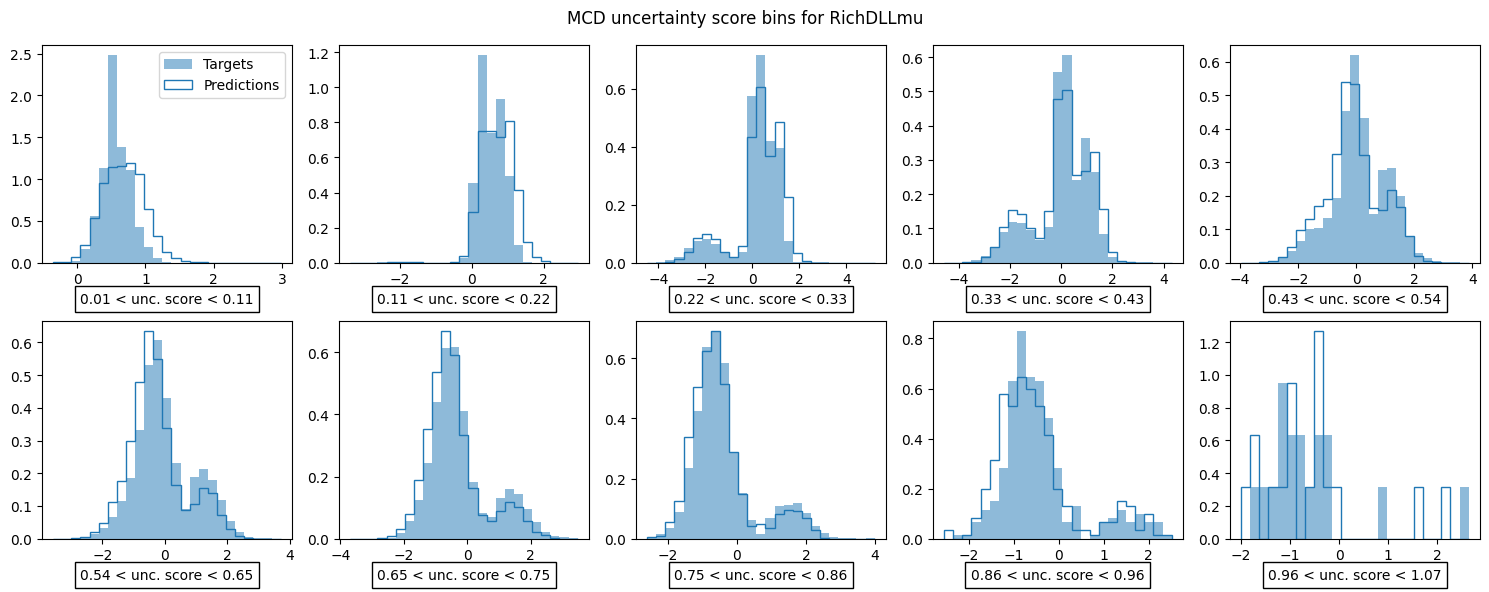

Jensen–Shannon distances:
0.23180331368852314, 0.2000224239466979, 0.12886659327752073, 0.09077089396120262, 0.11287504053677958, 0.11668474248883791, 0.09693792621738524, 0.09007718358309605, 0.16744628427218236, 0.47097663055590966
0.0 < unc. score < 0.12: Number of observations: 306
0.12 < unc. score < 0.23: Number of observations: 594
0.23 < unc. score < 0.35: Number of observations: 7918
0.35 < unc. score < 0.46: Number of observations: 31704
0.46 < unc. score < 0.58: Number of observations: 36613
0.58 < unc. score < 0.69: Number of observations: 16956
0.69 < unc. score < 0.81: Number of observations: 4555
0.81 < unc. score < 0.92: Number of observations: 1077
0.92 < unc. score < 1.03: Number of observations: 250
1.03 < unc. score < 1.15: Number of observations: 26


KeyboardInterrupt: 

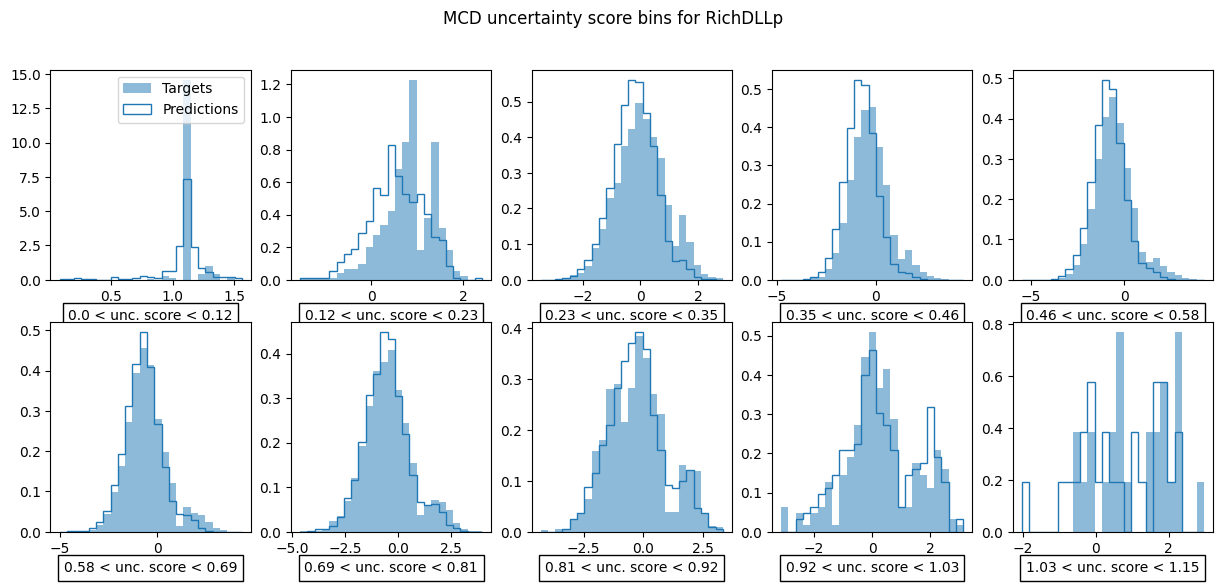

In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: 0.520943556378211
Correlation coefficient for RichDLLk: -0.18628467036760776
Correlation coefficient for RichDLLmu: 0.2418734941070551
Correlation coefficient for RichDLLp: 0.15208044417543742
Correlation coefficient for RichDLLbt: 0.6123689584446741


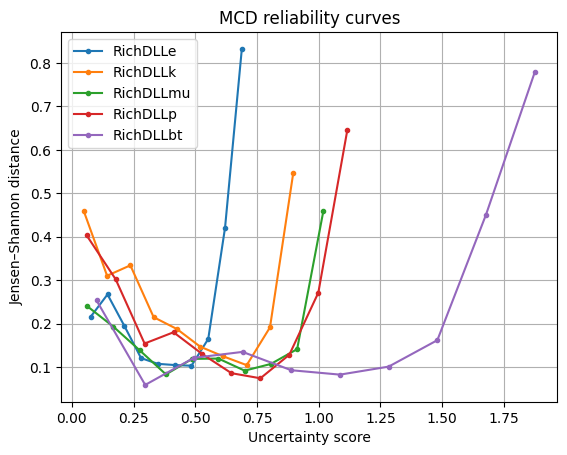

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

#### Quantile bins

0.04 < unc. score < 0.16: Number of observations: 10000
0.16 < unc. score < 0.26: Number of observations: 10000
0.26 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.33: Number of observations: 10000
0.33 < unc. score < 0.35: Number of observations: 10000
0.35 < unc. score < 0.37: Number of observations: 10000
0.37 < unc. score < 0.39: Number of observations: 10000
0.39 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.44: Number of observations: 10000
0.44 < unc. score < 0.71: Number of observations: 9999


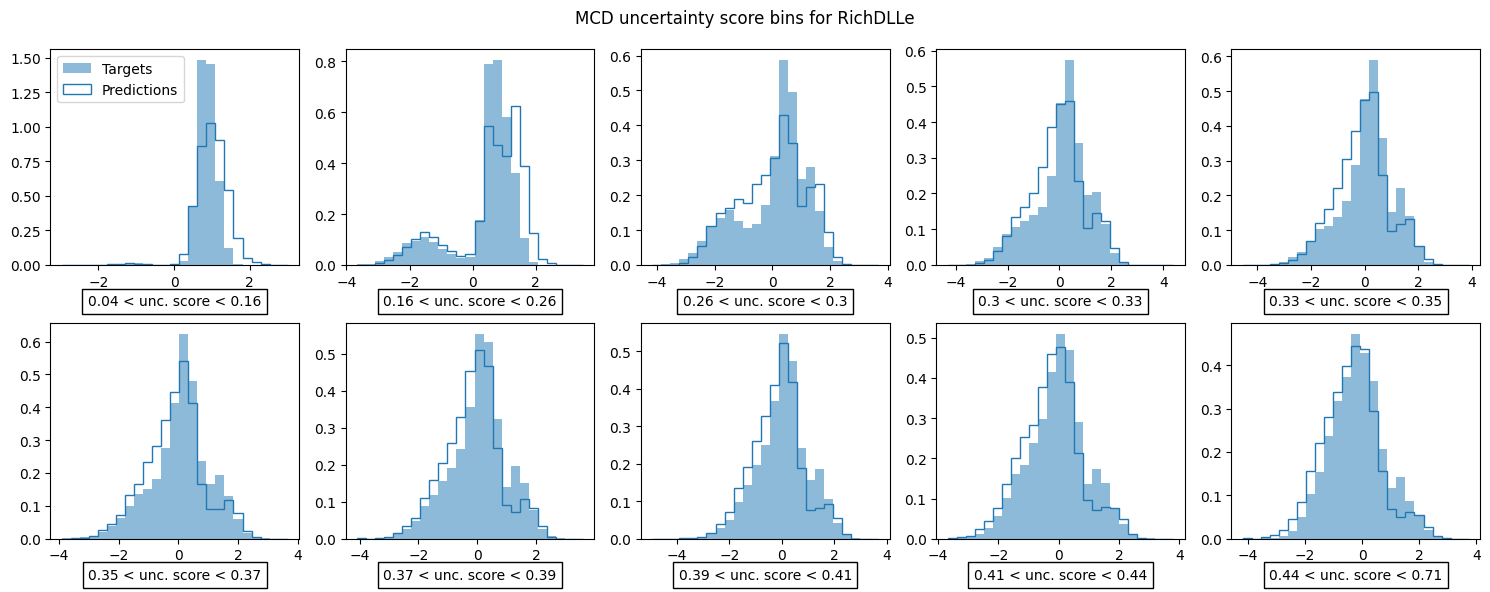

Jensen–Shannon distances:
0.23826096455788257, 0.2014949240834063, 0.1282688756371802, 0.11879711575741599, 0.11265034099395484, 0.10811691884627161, 0.1073648321185544, 0.10441642005609758, 0.1050960771671051, 0.10728821151972094
0.0 < unc. score < 0.28: Number of observations: 10000
0.28 < unc. score < 0.32: Number of observations: 10000
0.32 < unc. score < 0.35: Number of observations: 10000
0.35 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.44: Number of observations: 10000
0.44 < unc. score < 0.47: Number of observations: 10000
0.47 < unc. score < 0.5: Number of observations: 10000
0.5 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.99: Number of observations: 9999


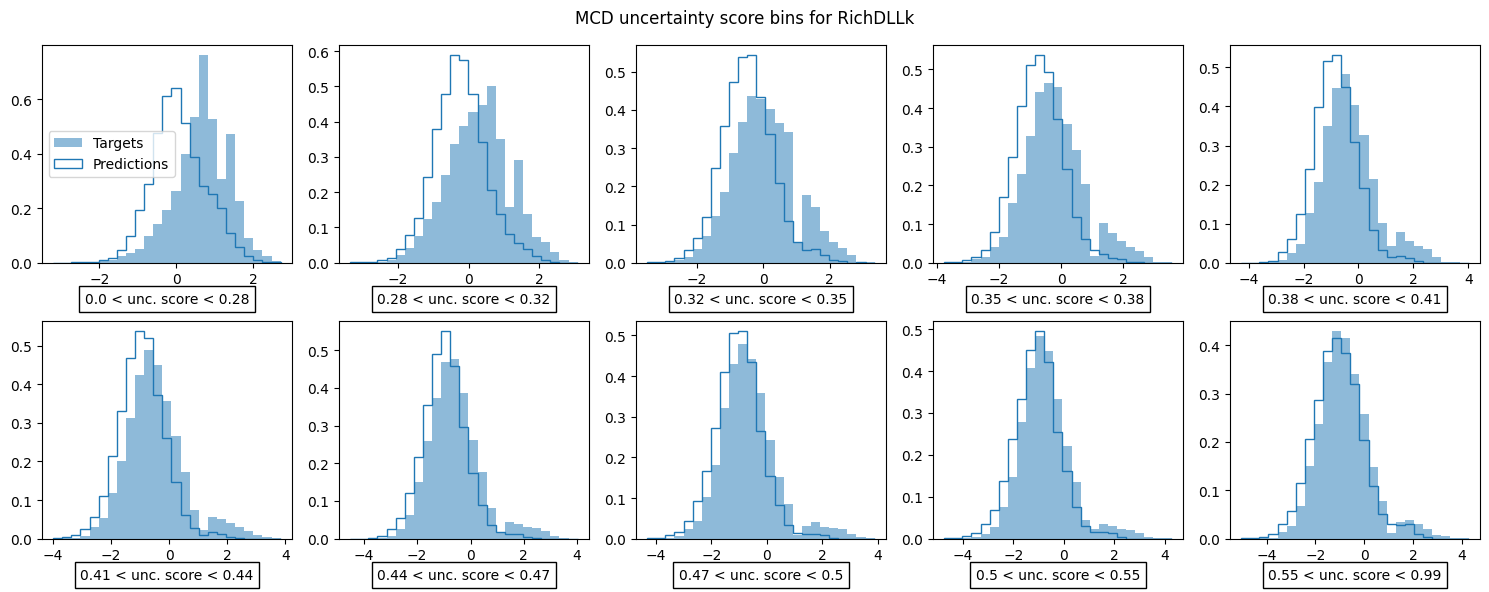

Jensen–Shannon distances:
0.311039803835294, 0.24884242490260028, 0.22139383525334855, 0.21745063059851497, 0.21194503625253577, 0.18617691044604834, 0.1598330050070977, 0.15433360697149434, 0.13882563857449357, 0.11104915496742242
0.01 < unc. score < 0.12: Number of observations: 10000
0.12 < unc. score < 0.21: Number of observations: 10000
0.21 < unc. score < 0.3: Number of observations: 10000
0.3 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.45: Number of observations: 10000
0.45 < unc. score < 0.51: Number of observations: 10000
0.51 < unc. score < 0.56: Number of observations: 10000
0.56 < unc. score < 0.61: Number of observations: 10000
0.61 < unc. score < 0.67: Number of observations: 10000
0.67 < unc. score < 1.08: Number of observations: 9999


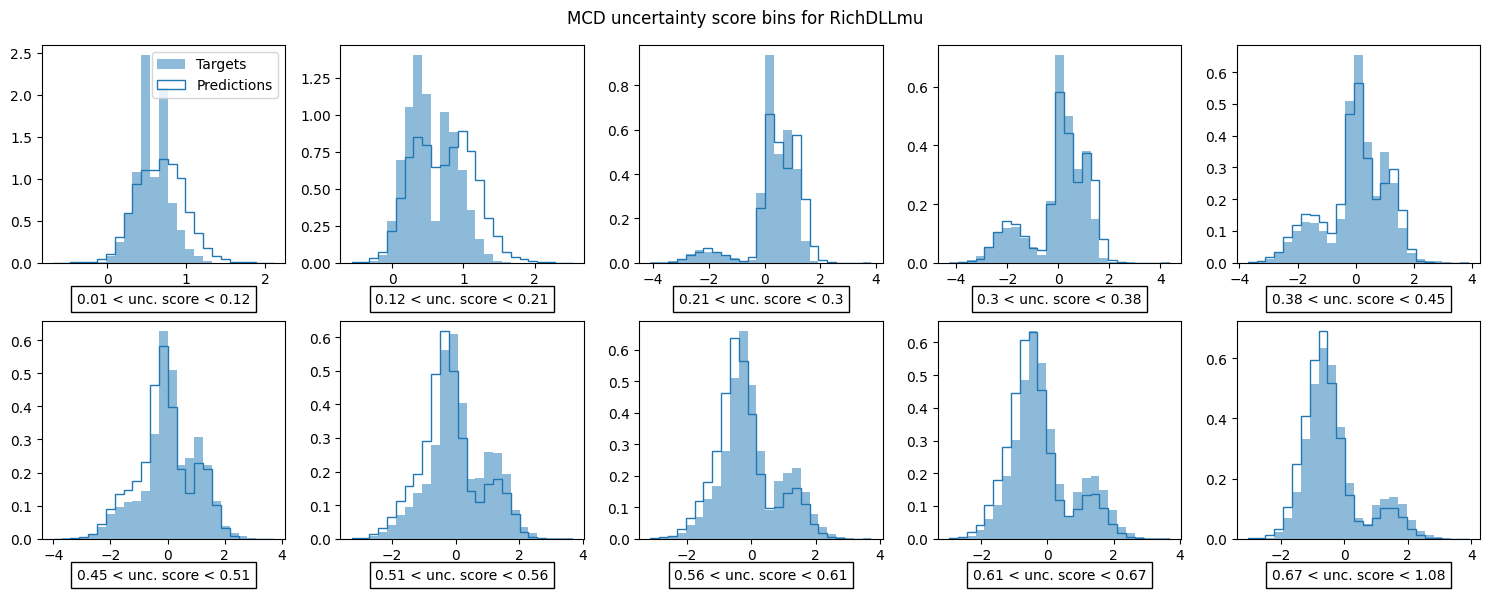

Jensen–Shannon distances:
0.2379410615261587, 0.21946515510751297, 0.15500348851574994, 0.10316966474470968, 0.08070399363225456, 0.10772705265086388, 0.13373028807248366, 0.1271130486088688, 0.11644014988484529, 0.0919478005048728
0.0 < unc. score < 0.36: Number of observations: 10000
0.36 < unc. score < 0.4: Number of observations: 10000
0.4 < unc. score < 0.43: Number of observations: 10000
0.43 < unc. score < 0.46: Number of observations: 10000
0.46 < unc. score < 0.49: Number of observations: 10000
0.49 < unc. score < 0.52: Number of observations: 10000
0.52 < unc. score < 0.55: Number of observations: 10000
0.55 < unc. score < 0.59: Number of observations: 10000
0.59 < unc. score < 0.65: Number of observations: 10000
0.65 < unc. score < 1.14: Number of observations: 9999


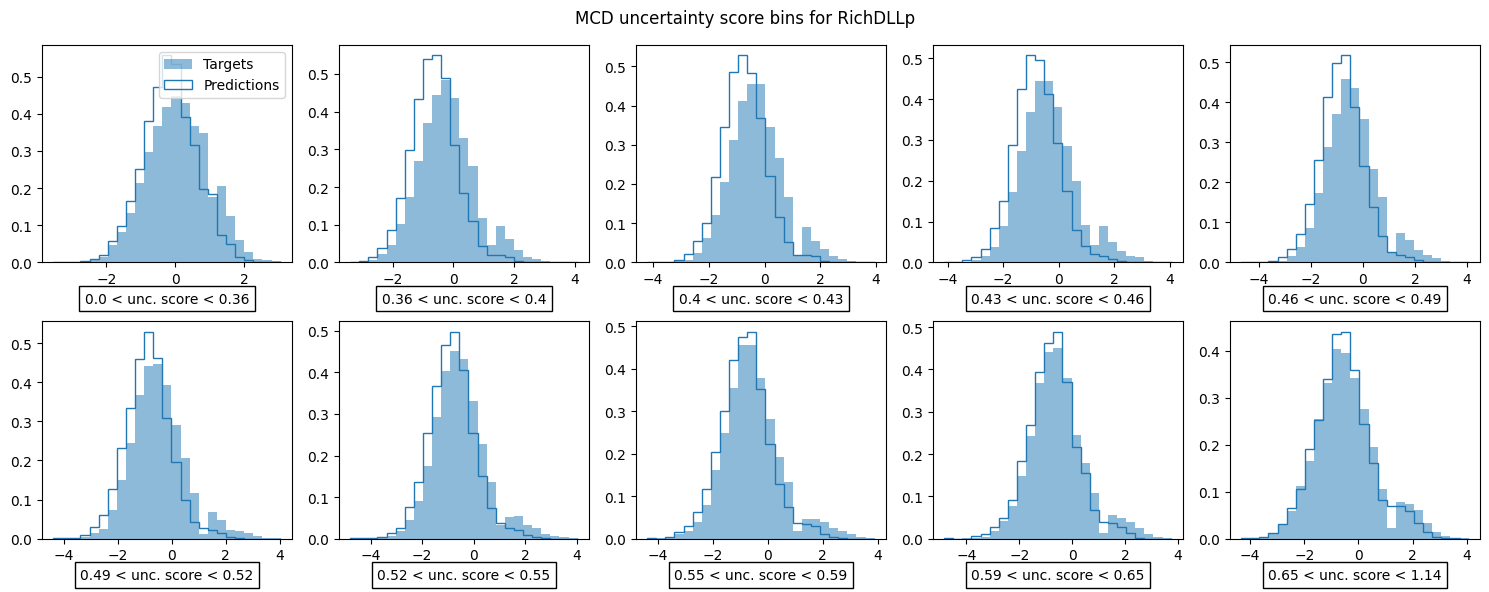

Jensen–Shannon distances:
0.132592375318209, 0.18782339488693658, 0.19061798758734516, 0.18197762485262078, 0.16513875988523313, 0.1612644750878282, 0.127217128425607, 0.113371333835983, 0.09862128839578477, 0.07829518492079153
0.0 < unc. score < 0.41: Number of observations: 10000
0.41 < unc. score < 0.48: Number of observations: 10000
0.48 < unc. score < 0.54: Number of observations: 10000
0.54 < unc. score < 0.59: Number of observations: 10000
0.59 < unc. score < 0.66: Number of observations: 10000
0.66 < unc. score < 0.73: Number of observations: 10000
0.73 < unc. score < 0.81: Number of observations: 10000
0.81 < unc. score < 0.9: Number of observations: 10000
0.9 < unc. score < 1.03: Number of observations: 10000
1.03 < unc. score < 1.87: Number of observations: 9999


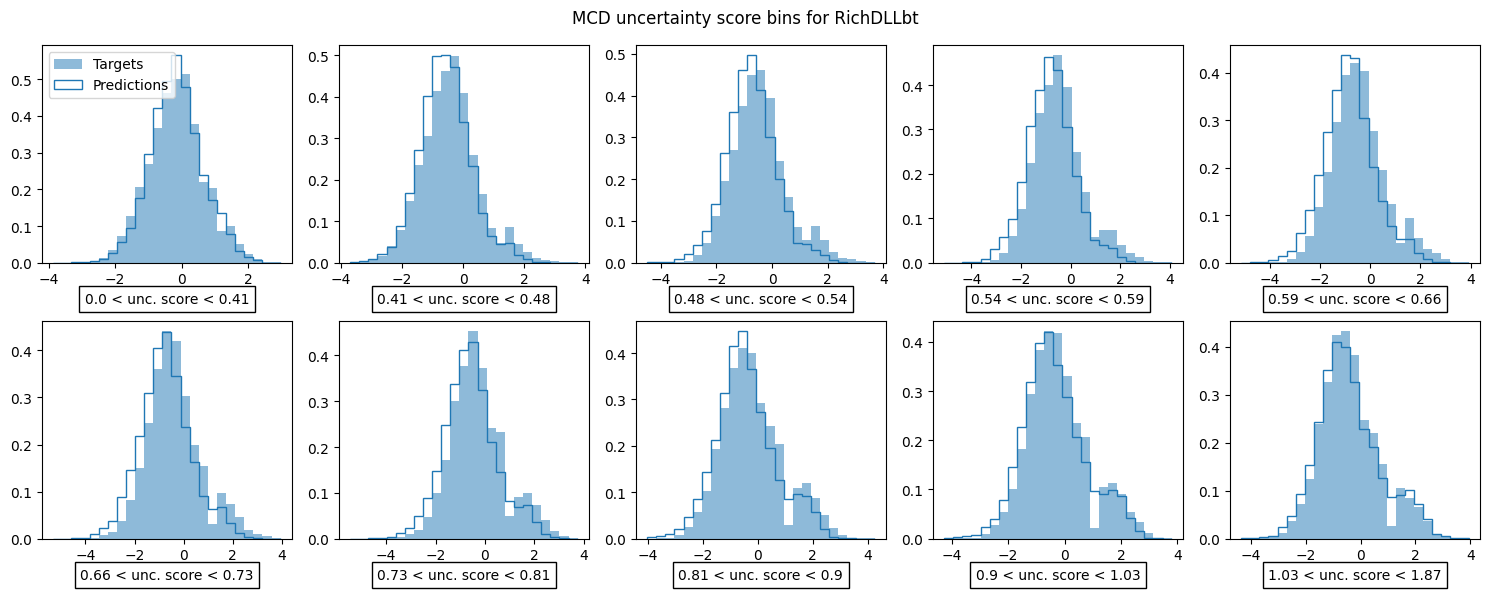

Jensen–Shannon distances:
0.06280309218409655, 0.0865497693385152, 0.1252107158837768, 0.1340517614456001, 0.1437382814305264, 0.13916525190645984, 0.12257063524852395, 0.10915409032695919, 0.09839411654664507, 0.07244047907044245


In [ ]:
all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i)
  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

Correlation coefficient for RichDLLe: -0.836997547027548
Correlation coefficient for RichDLLk: -0.9447786304349812
Correlation coefficient for RichDLLmu: -0.7536507406627427
Correlation coefficient for RichDLLp: -0.6422051181784504
Correlation coefficient for RichDLLbt: -0.11753500672527016


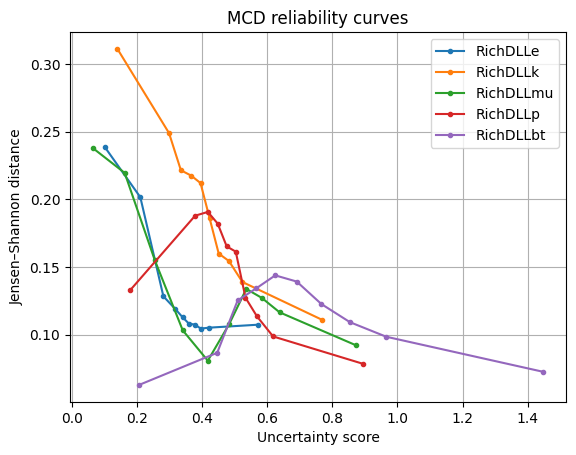

[-0.836997547027548,
 -0.9447786304349812,
 -0.7536507406627427,
 -0.6422051181784504,
 -0.11753500672527016]

In [ ]:
plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')

## Feature Densities method

### Uncertainty estimation

In [ ]:
from feature_densities.feature_density_evaluator import evaluate_model as fd_evaluate_model

train_embeddings = np.load(embeddings_dir + f'{PARTICLE}_train_embeddings.npy')
train_embeddings.shape

(948325, 128)

In [ ]:
fd_uncertainty_normalized, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                 likelihood_method='normalized')

print('Feature Densities using NORMALIZED uncertainty score for x_sample:')
fd_uncertainty_normalized.shape

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 6s 2ms/step
Estimating sample's feature densities


100%|██████████| 128/128 [00:41<00:00,  3.12it/s]

Feature Densities using NORMALIZED uncertainty score for x_sample:


TensorShape([100000])

In [ ]:
# Save FD uncertainties normalized
# np.save(output_dir + f'{PARTICLE}_fd_uncertainty_normalized.npy', fd_uncertainty_normalized)

### Plot FD uncertainties

#### Linear bins

0.06 < unc. score < 0.15: Number of observations: 1100
0.15 < unc. score < 0.24: Number of observations: 5027
0.24 < unc. score < 0.32: Number of observations: 7884
0.32 < unc. score < 0.41: Number of observations: 10820
0.41 < unc. score < 0.5: Number of observations: 14738
0.5 < unc. score < 0.59: Number of observations: 17568
0.59 < unc. score < 0.68: Number of observations: 17230
0.68 < unc. score < 0.77: Number of observations: 13197
0.77 < unc. score < 0.86: Number of observations: 10050
0.86 < unc. score < 0.95: Number of observations: 2385


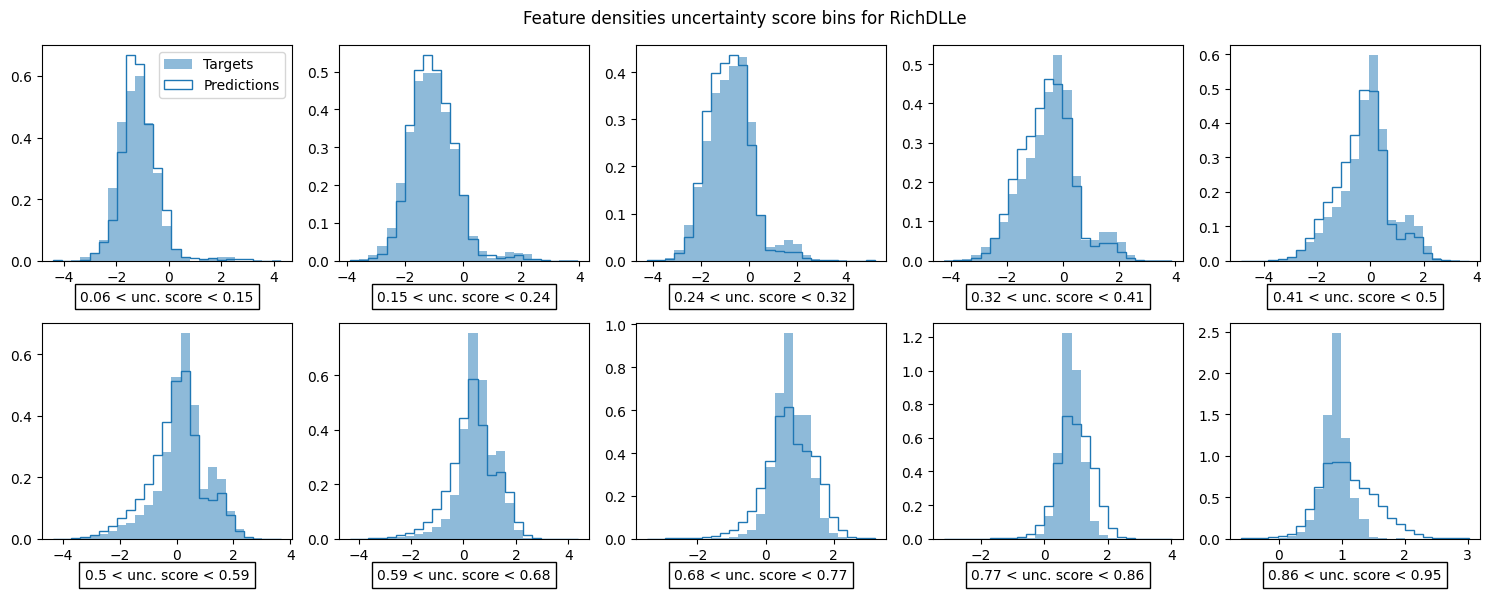

Jensen–Shannon distances:
0.10145983679935033, 0.06028387015658485, 0.06942302840498994, 0.08252628579880629, 0.09506119187690866, 0.11582859591921317, 0.14073507338112856, 0.18000087200133688, 0.2295654219552911, 0.3364838123207263
0.06 < unc. score < 0.15: Number of observations: 1100
0.15 < unc. score < 0.24: Number of observations: 5027
0.24 < unc. score < 0.32: Number of observations: 7884
0.32 < unc. score < 0.41: Number of observations: 10820
0.41 < unc. score < 0.5: Number of observations: 14738
0.5 < unc. score < 0.59: Number of observations: 17568
0.59 < unc. score < 0.68: Number of observations: 17230
0.68 < unc. score < 0.77: Number of observations: 13197
0.77 < unc. score < 0.86: Number of observations: 10050
0.86 < unc. score < 0.95: Number of observations: 2385


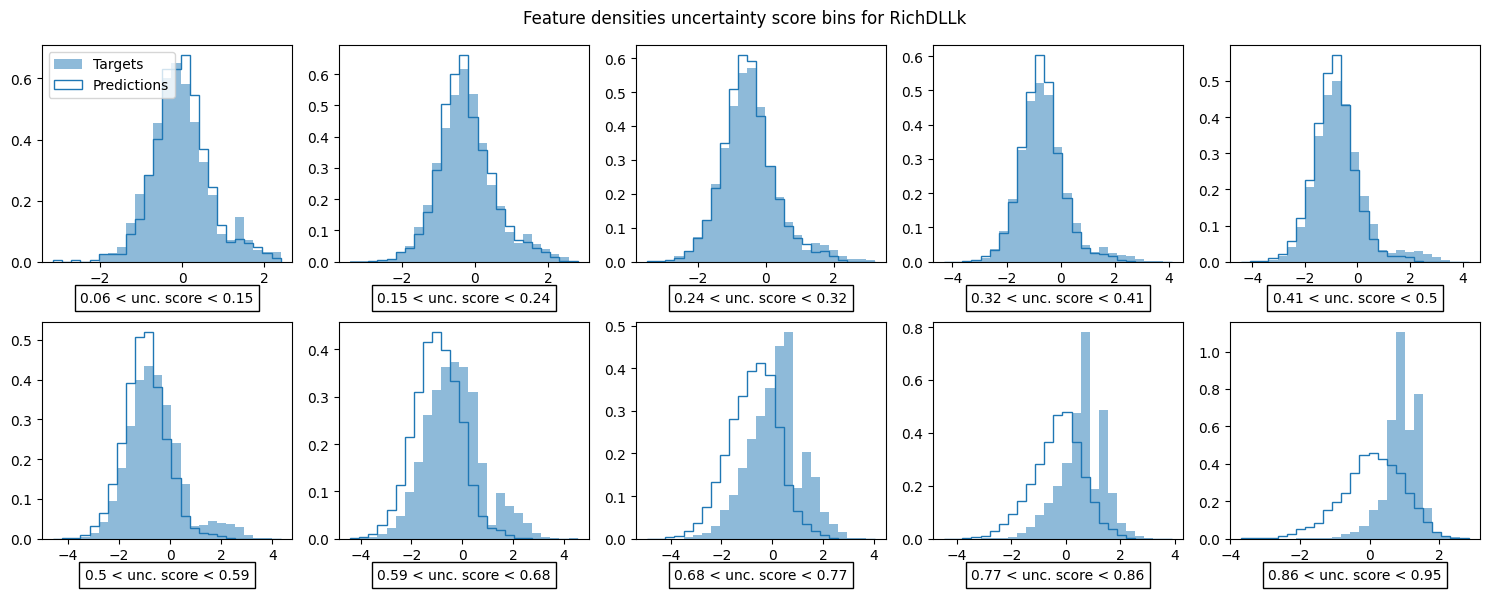

Jensen–Shannon distances:
0.07989721565816474, 0.061576166390665585, 0.0646080922002668, 0.07409466473702155, 0.10606271690735174, 0.16194889375503352, 0.23855889004210554, 0.3116454176428482, 0.37128049487169834, 0.4271558725426341
0.06 < unc. score < 0.15: Number of observations: 1100
0.15 < unc. score < 0.24: Number of observations: 5027
0.24 < unc. score < 0.32: Number of observations: 7884
0.32 < unc. score < 0.41: Number of observations: 10820
0.41 < unc. score < 0.5: Number of observations: 14738
0.5 < unc. score < 0.59: Number of observations: 17568
0.59 < unc. score < 0.68: Number of observations: 17230
0.68 < unc. score < 0.77: Number of observations: 13197
0.77 < unc. score < 0.86: Number of observations: 10050
0.86 < unc. score < 0.95: Number of observations: 2385


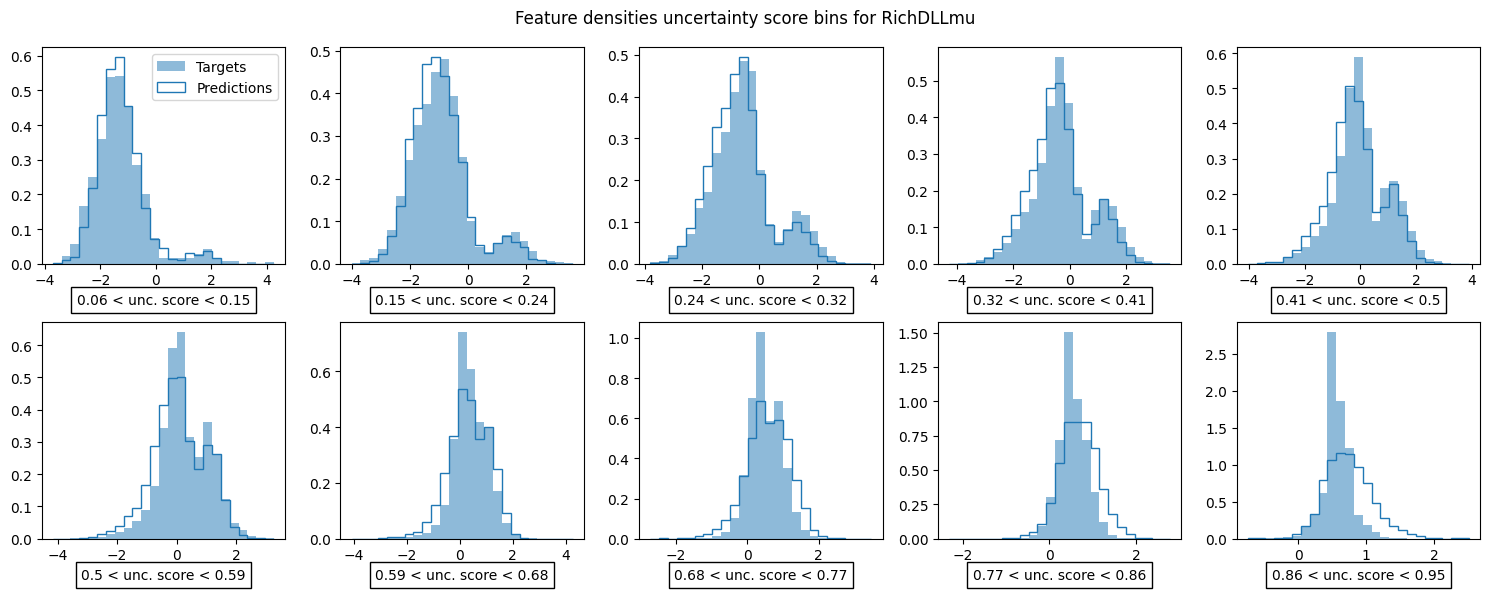

Jensen–Shannon distances:
0.09530031974816977, 0.07020856740127494, 0.07903788431231987, 0.09020721861696224, 0.0992014410245585, 0.10708860795062544, 0.12151690779035187, 0.15433524367218457, 0.1926993790629779, 0.3017947724845152
0.06 < unc. score < 0.15: Number of observations: 1100
0.15 < unc. score < 0.24: Number of observations: 5027
0.24 < unc. score < 0.32: Number of observations: 7884
0.32 < unc. score < 0.41: Number of observations: 10820
0.41 < unc. score < 0.5: Number of observations: 14738
0.5 < unc. score < 0.59: Number of observations: 17568
0.59 < unc. score < 0.68: Number of observations: 17230
0.68 < unc. score < 0.77: Number of observations: 13197
0.77 < unc. score < 0.86: Number of observations: 10050
0.86 < unc. score < 0.95: Number of observations: 2385


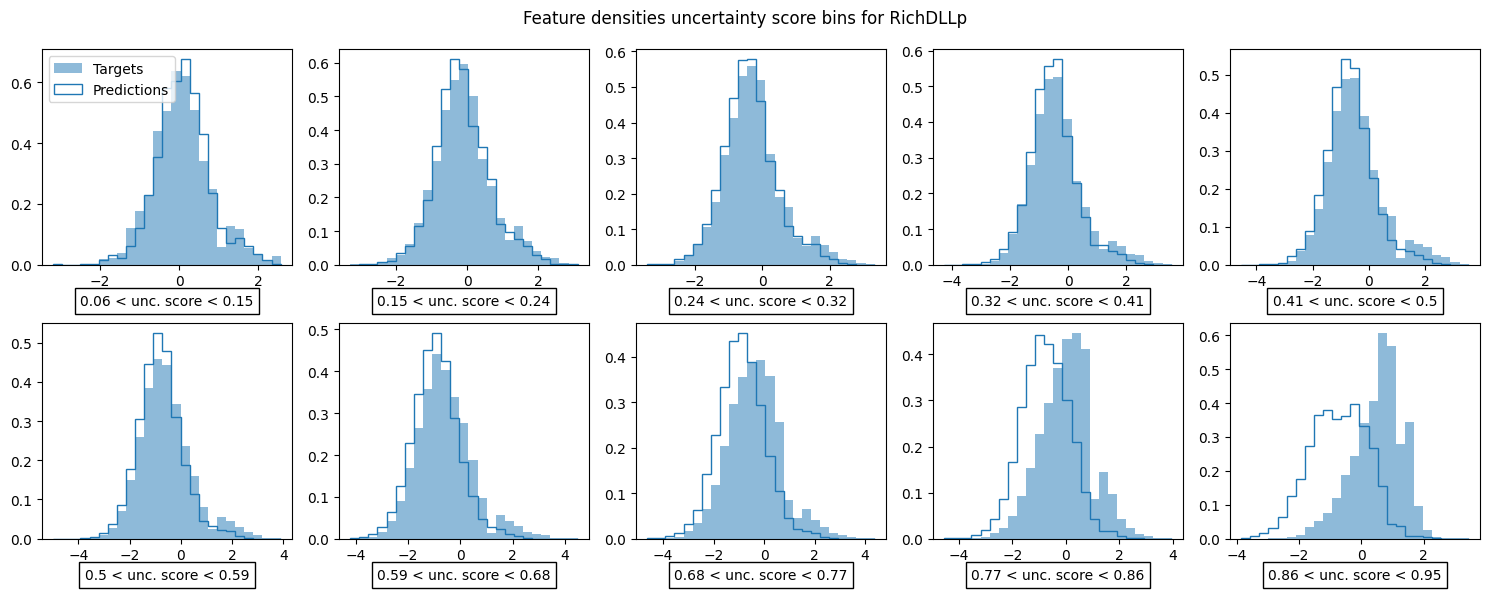

Jensen–Shannon distances:
0.09164649333519494, 0.06476955639401168, 0.07167786017066911, 0.08440087539180044, 0.10448809147608012, 0.10551271884898351, 0.13582927856109298, 0.1914291537602017, 0.29215974427465274, 0.46506909292926246
0.06 < unc. score < 0.15: Number of observations: 1100
0.15 < unc. score < 0.24: Number of observations: 5027
0.24 < unc. score < 0.32: Number of observations: 7884
0.32 < unc. score < 0.41: Number of observations: 10820
0.41 < unc. score < 0.5: Number of observations: 14738
0.5 < unc. score < 0.59: Number of observations: 17568
0.59 < unc. score < 0.68: Number of observations: 17230
0.68 < unc. score < 0.77: Number of observations: 13197
0.77 < unc. score < 0.86: Number of observations: 10050
0.86 < unc. score < 0.95: Number of observations: 2385


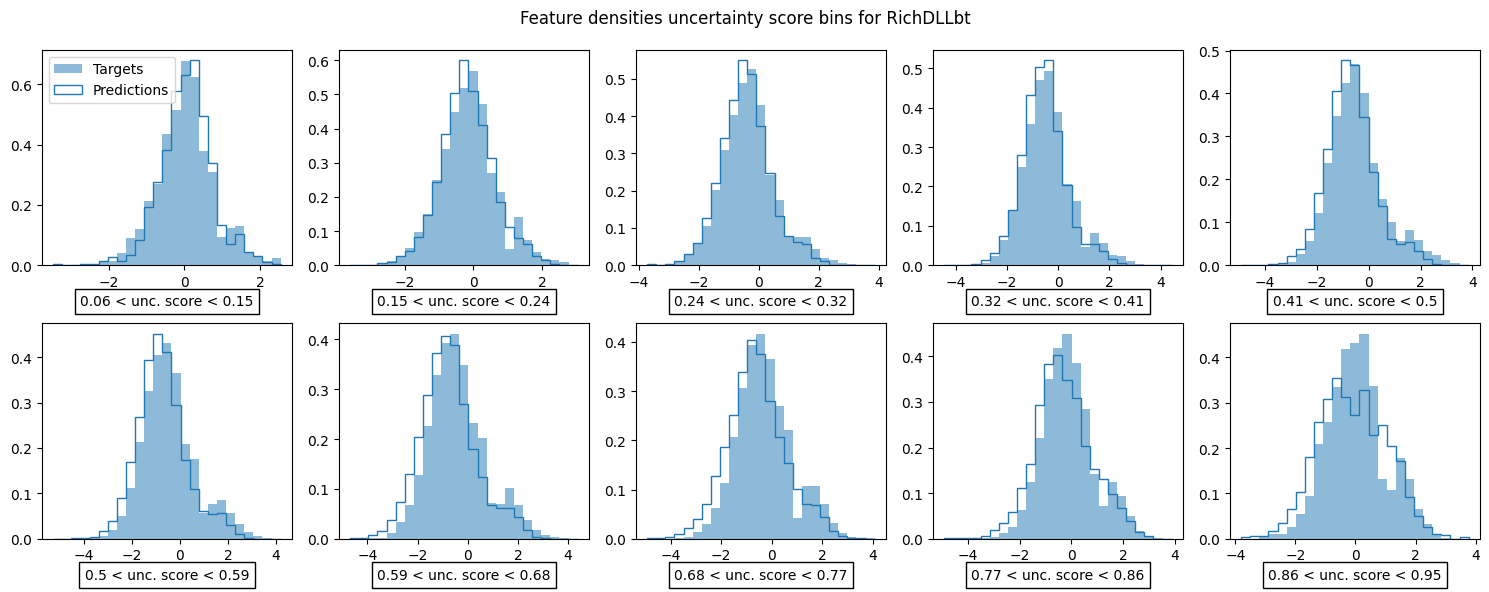

Jensen–Shannon distances:
0.08991639499848361, 0.08035642378714603, 0.06810192338279239, 0.08509658040176662, 0.09932213704645843, 0.11361805590207504, 0.1255990388658776, 0.13157360624584258, 0.10926896651672612, 0.14530397894748534


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.8613492254034542
Correlation coefficient for RichDLLk: 0.9398164249339928
Correlation coefficient for RichDLLmu: 0.8332629122655022
Correlation coefficient for RichDLLp: 0.8238087508648003
Correlation coefficient for RichDLLbt: 0.8588182501994955


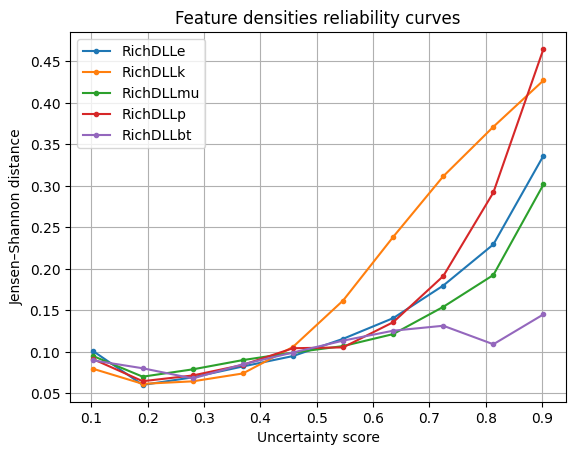

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

#### Quantile bins

0.07 < unc. score < 0.28: Number of observations: 10000
0.28 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.45: Number of observations: 10000
0.45 < unc. score < 0.51: Number of observations: 10000
0.51 < unc. score < 0.56: Number of observations: 10000
0.56 < unc. score < 0.61: Number of observations: 10000
0.61 < unc. score < 0.66: Number of observations: 10000
0.66 < unc. score < 0.71: Number of observations: 10000
0.71 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


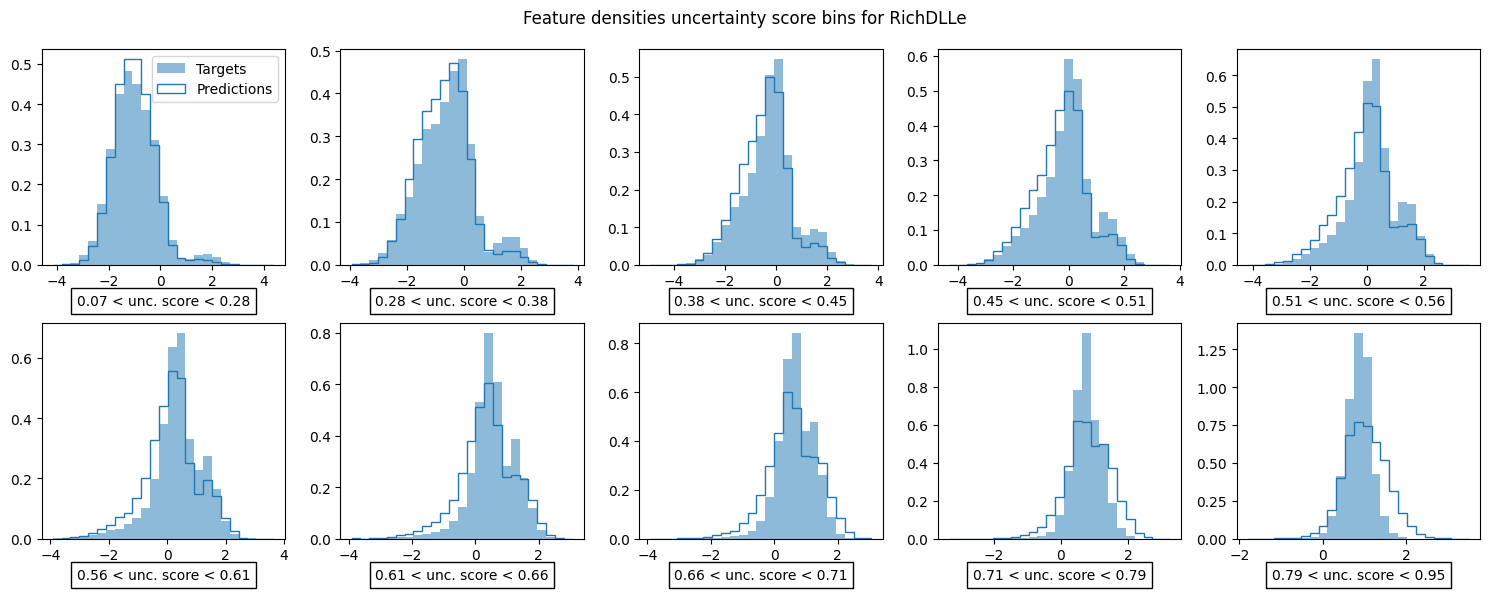

Jensen–Shannon distances:
0.05783082527893578, 0.07847014862839535, 0.08985460997977249, 0.09921025508475538, 0.11336957448203801, 0.1227446809362774, 0.13963305144337973, 0.16994365707411835, 0.19736528949181004, 0.25475956301753905
0.07 < unc. score < 0.28: Number of observations: 10000
0.28 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.45: Number of observations: 10000
0.45 < unc. score < 0.51: Number of observations: 10000
0.51 < unc. score < 0.56: Number of observations: 10000
0.56 < unc. score < 0.61: Number of observations: 10000
0.61 < unc. score < 0.66: Number of observations: 10000
0.66 < unc. score < 0.71: Number of observations: 10000
0.71 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


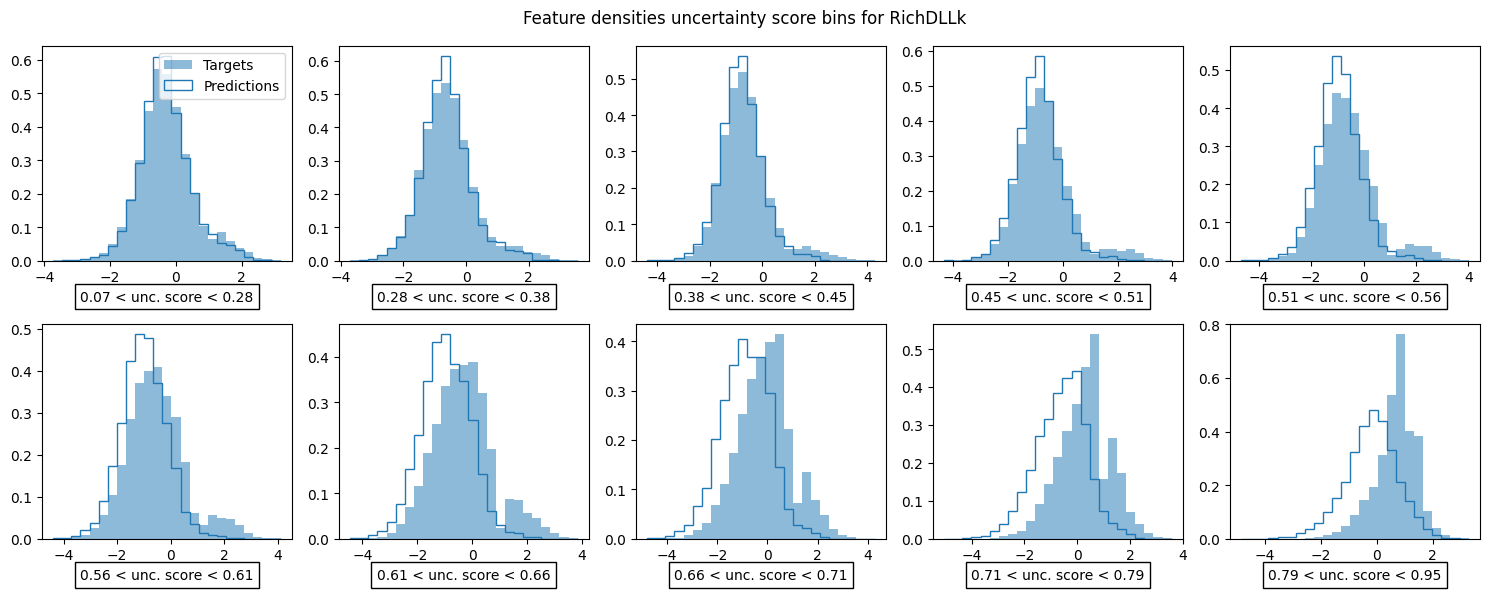

Jensen–Shannon distances:
0.05303013514435524, 0.06543247519306598, 0.09491296378227994, 0.11822642501477837, 0.15250826855114352, 0.18746262314064904, 0.23519091260237107, 0.2787385408111033, 0.3228430085801954, 0.3641563747370063
0.07 < unc. score < 0.28: Number of observations: 10000
0.28 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.45: Number of observations: 10000
0.45 < unc. score < 0.51: Number of observations: 10000
0.51 < unc. score < 0.56: Number of observations: 10000
0.56 < unc. score < 0.61: Number of observations: 10000
0.61 < unc. score < 0.66: Number of observations: 10000
0.66 < unc. score < 0.71: Number of observations: 10000
0.71 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


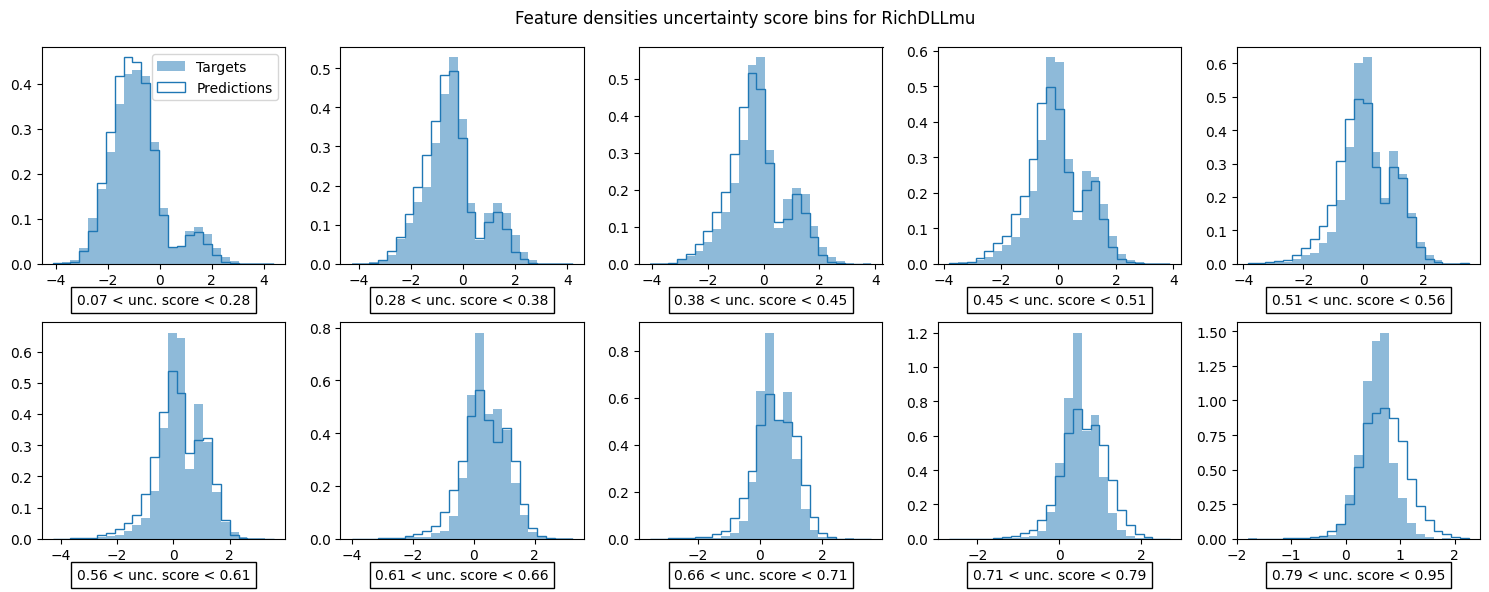

Jensen–Shannon distances:
0.06528307946274707, 0.08801885351717478, 0.09715953267107079, 0.10406976840953602, 0.10740622258983011, 0.11820053452329157, 0.124119221392263, 0.13847098476566075, 0.15963339685710207, 0.21792208282393594
0.07 < unc. score < 0.28: Number of observations: 10000
0.28 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.45: Number of observations: 10000
0.45 < unc. score < 0.51: Number of observations: 10000
0.51 < unc. score < 0.56: Number of observations: 10000
0.56 < unc. score < 0.61: Number of observations: 10000
0.61 < unc. score < 0.66: Number of observations: 10000
0.66 < unc. score < 0.71: Number of observations: 10000
0.71 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


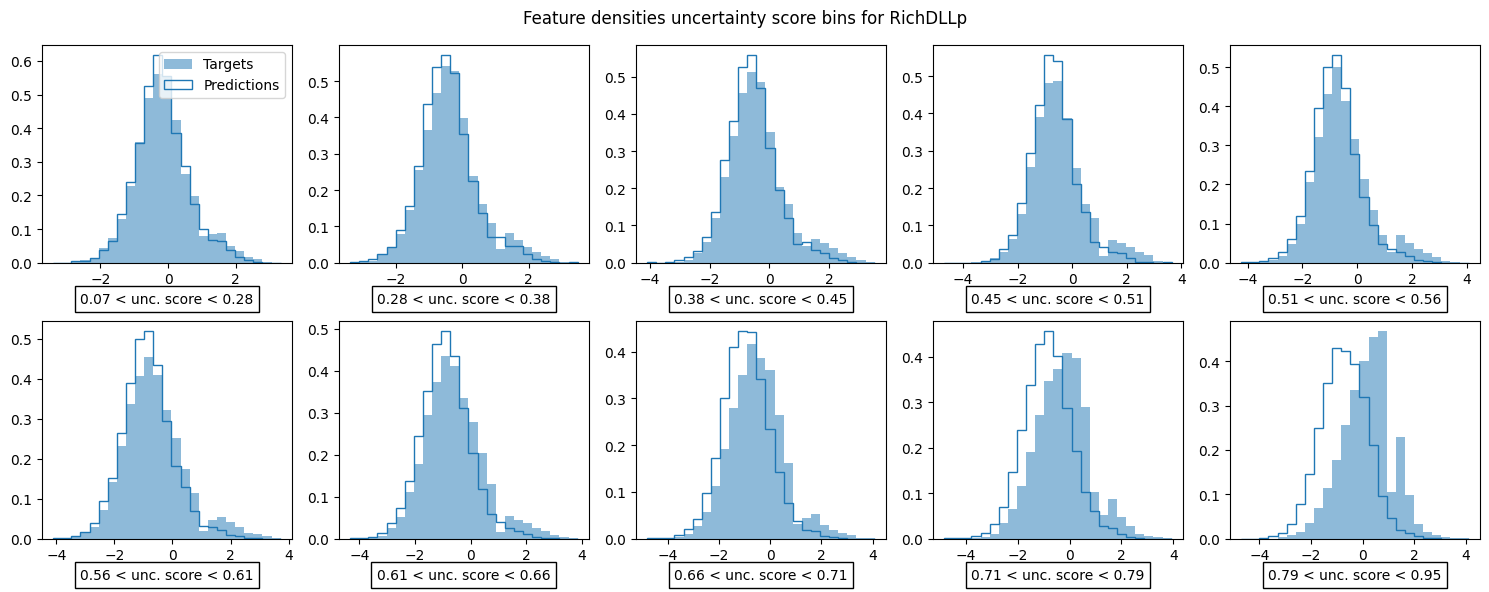

Jensen–Shannon distances:
0.05344418609316305, 0.08090463969334194, 0.09416671763145919, 0.10881706461766351, 0.10687082667691876, 0.10965262860364004, 0.12901780010411035, 0.15488482852651528, 0.21380554638418353, 0.331794583287389
0.07 < unc. score < 0.28: Number of observations: 10000
0.28 < unc. score < 0.38: Number of observations: 10000
0.38 < unc. score < 0.45: Number of observations: 10000
0.45 < unc. score < 0.51: Number of observations: 10000
0.51 < unc. score < 0.56: Number of observations: 10000
0.56 < unc. score < 0.61: Number of observations: 10000
0.61 < unc. score < 0.66: Number of observations: 10000
0.66 < unc. score < 0.71: Number of observations: 10000
0.71 < unc. score < 0.79: Number of observations: 10000
0.79 < unc. score < 0.95: Number of observations: 9999


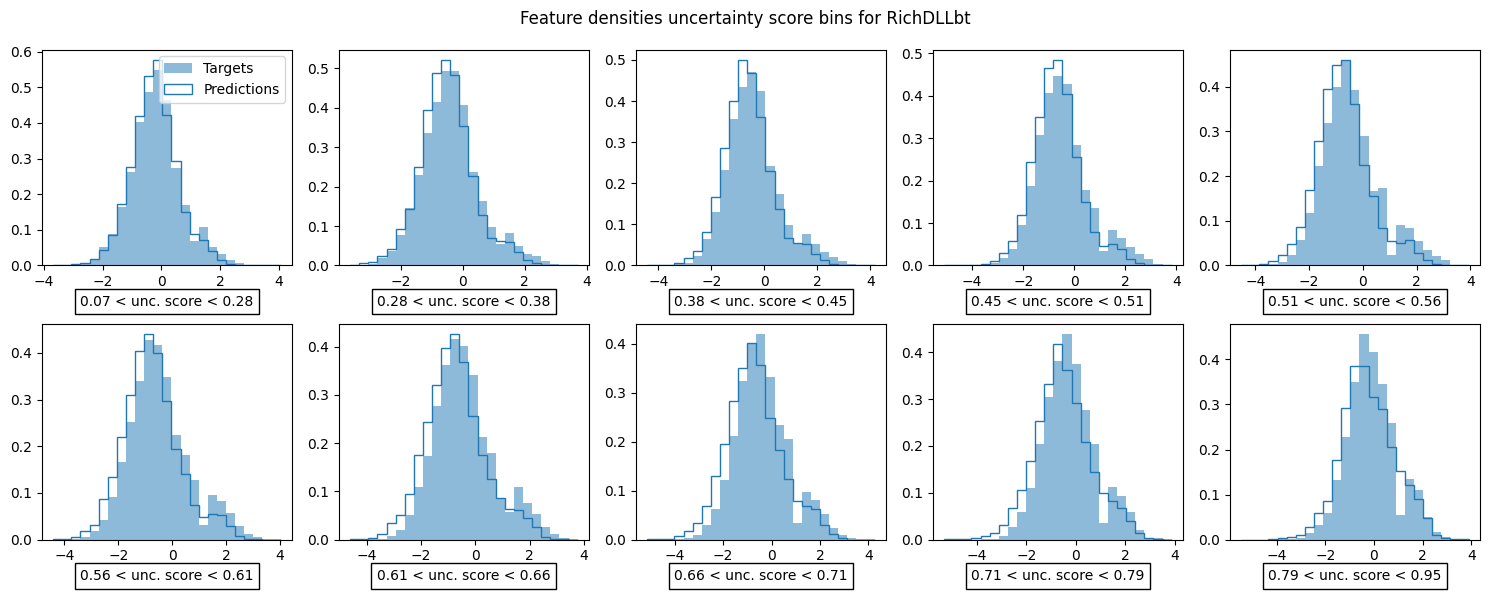

Jensen–Shannon distances:
0.056098265615216254, 0.07013421050401436, 0.0940051338645841, 0.10236646236602462, 0.12316627533056745, 0.11190543090938623, 0.12088892053313717, 0.133022692486946, 0.1264733639237126, 0.10912367434366425


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.9512340453492599
Correlation coefficient for RichDLLk: 0.9643612544561933
Correlation coefficient for RichDLLmu: 0.9371228280013425
Correlation coefficient for RichDLLp: 0.8741816653656902
Correlation coefficient for RichDLLbt: 0.8264348714238549


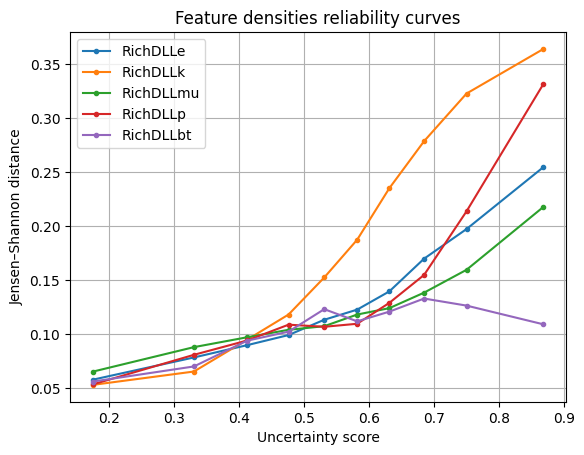

[0.9512340453492599,
 0.9643612544561933,
 0.9371228280013425,
 0.8741816653656902,
 0.8264348714238549]

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

# Run N times FD Method

In [ ]:
N = 30
fd_correlations = []
fd_uncertainties = []

for i in range(N):
  print(f'Run {i + 1}')

  fd_uncertainty_normalized, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                  likelihood_method='normalized')
  fd_uncertainties += [fd_uncertainty_normalized]

  all_fd_bin_edges, all_fd_js_distances = [], []

  for i in range(5):
    fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
        y_sample, t_generated, fd_uncertainty_normalized, 'Feature densities', 'quantiles', particle_index = i)

    all_fd_bin_edges += [fd_bin_edges]
    all_fd_js_distances += [fd_js_distances]

  fd_correlations += [plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')]


# Test 1 - Averaging distributions

In [ ]:
import tensorflow as tf
import pandas as pd

stacked_tensors = tf.stack(fd_uncertainties)
average_tensor = tf.reduce_mean(stacked_tensors, axis=0)

all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, average_tensor, 'Feature densities', 'quantiles', particle_index = i)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

correlation = [plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')]



df = pd.DataFrame(correlation, columns=DLL_COLUMNS)
print(df)

# Test 2 - Averaging Correlations

In [ ]:
# Test 2
import pandas as pd

df = pd.DataFrame(fd_correlations, columns=DLL_COLUMNS)
means = df.mean(axis=0)
df.loc['Mean'] = means
print(df)

      RichDLLe  RichDLLk  RichDLLmu  RichDLLp  RichDLLbt
0     0.955268  0.957049   0.938374  0.850708   0.835699
1     0.939143  0.950884   0.929917  0.866431   0.762835
2     0.946733  0.962005   0.941627  0.869656   0.800498
3     0.946175  0.955687   0.959135  0.868271   0.813763
4     0.955423  0.956911   0.954546  0.883724   0.822334
5     0.946136  0.949633   0.951035  0.855792   0.831560
6     0.942284  0.954909   0.939950  0.870794   0.766378
7     0.944631  0.954508   0.948856  0.869586   0.790353
8     0.951109  0.958945   0.944860  0.877522   0.869616
9     0.943569  0.956436   0.930419  0.866358   0.733686
10    0.949951  0.953863   0.950389  0.858004   0.792651
11    0.945373  0.958373   0.919529  0.873292   0.890320
12    0.947434  0.959278   0.946303  0.857417   0.794051
13    0.949826  0.956506   0.935407  0.861858   0.725558
14    0.948303  0.957397   0.925429  0.871802   0.801737
15    0.962481  0.961554   0.931280  0.876734   0.845149
16    0.932904  0.955389   0.94

# Run N Times MCD

In [ ]:
N = 30
mcd_correlations = []
mcd_uncertainties = []

for i in range(N):
  print(f'Run {i + 1}')


  mcd_uncertainty = mcd_evaluate_model(model, x_sample, MCD_ENSEMBLE_SIZE)[0]

  mcd_uncertainties += [mcd_uncertainty]

  all_mcd_bin_edges, all_mcd_js_distances = [], []

  for i in range(5):
    mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
        y_sample, t_generated, mcd_uncertainty, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i)


    all_mcd_bin_edges += [mcd_bin_edges]
    all_mcd_js_distances += [mcd_js_distances]


  mcd_correlations += [plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')]

In [ ]:
stacked_tensors_mcd = tf.stack(mcd_uncertainties)
average_tensor_mcd = tf.reduce_mean(stacked_tensors_mcd, axis=0)

all_mcd_bin_edges, all_mcd_js_distances = [], []

for i in range(5):
  mcd_bin_edges, mcd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, average_tensor_mcd, uncertainty_type = 'MCD', bin_type='quantiles', particle_index = i)


  all_mcd_bin_edges += [mcd_bin_edges]
  all_mcd_js_distances += [mcd_js_distances]

correlation = [plot_all_distances(all_mcd_bin_edges, all_mcd_js_distances, 'MCD')]
df = pd.DataFrame(correlation, columns=DLL_COLUMNS)
print(df)

In [ ]:
df = pd.DataFrame(mcd_correlations, columns=DLL_COLUMNS)
means = df.mean(axis=0)
df.loc['Mean'] = means
print(df)

      RichDLLe  RichDLLk  RichDLLmu  RichDLLp  RichDLLbt
0    -0.813167 -0.961324  -0.743060 -0.661980  -0.266710
1    -0.834668 -0.942325  -0.750009 -0.700651  -0.196476
2    -0.839370 -0.964667  -0.770816 -0.680705  -0.262257
3    -0.834664 -0.967753  -0.785621 -0.637131  -0.249239
4    -0.818552 -0.946164  -0.754736 -0.629664  -0.219335
5    -0.868969 -0.941012  -0.776779 -0.632771  -0.286731
6    -0.876800 -0.957328  -0.782450 -0.537908  -0.291552
7    -0.863464 -0.948100  -0.771538 -0.630873  -0.223575
8    -0.843761 -0.922014  -0.754357 -0.721187  -0.172120
9    -0.858123 -0.936750  -0.780617 -0.600092  -0.189901
10   -0.842673 -0.955021  -0.769074 -0.680149  -0.244999
11   -0.847550 -0.948379  -0.773433 -0.631636  -0.259280
12   -0.851514 -0.938885  -0.743221 -0.675075  -0.258305
13   -0.826644 -0.883595  -0.745624 -0.581629  -0.216167
14   -0.847172 -0.946776  -0.789775 -0.678426  -0.239225
15   -0.859212 -0.944688  -0.772791 -0.652374  -0.286607
16   -0.858726 -0.931100  -0.77

## Uncertainty heatmaps

In [ ]:
def uncertainty_scatter_plot_fd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  plt.title('Feature densities heatmap')
  plt.scatter(momentum, eta, .1, uncertainties, cmap='inferno')
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

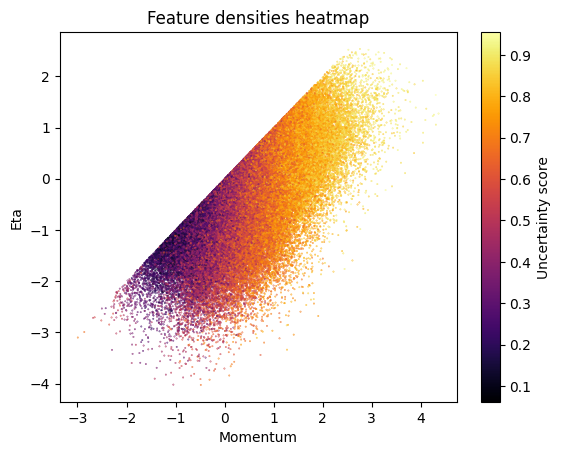

In [ ]:
uncertainty_scatter_plot_fd(x_sample, fd_uncertainty_normalized)

In [ ]:
def uncertainty_hist2d_fd(x_real, uncertainties, n_bins=100):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
  momentum_indices = np.digitize(momentum, momentum_edges)
  eta_indices = np.digitize(eta, eta_edges)

  heatmap = []

  for i in range(1, n_bins + 1):
    row = []
    for j in range(1, n_bins + 1):
      row += [uncertainties[(momentum_indices == j) & (eta_indices == i)].mean()]
    heatmap += [row]

  plt.title('Feature densities heatmap')
  plt.imshow(heatmap, 'inferno')
  plt.gca().invert_yaxis()
  plt.colorbar(label='Uncertainty score')
  plt.xlabel('Momentum')
  plt.ylabel('Eta')
  plt.show()

In [ ]:
uncertainty_hist2d_fd(x_sample, fd_uncertainty_normalized)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'

In [ ]:
def uncertainty_scatter_plot_mcd(x_real, uncertainties):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for i, ax in enumerate(axes.flatten()[:-1]):
    ax.set_title(DLL_COLUMNS[i])
    scatter = ax.scatter(momentum, eta, .1, uncertainties[:, i], cmap='inferno')
    plt.colorbar(scatter, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

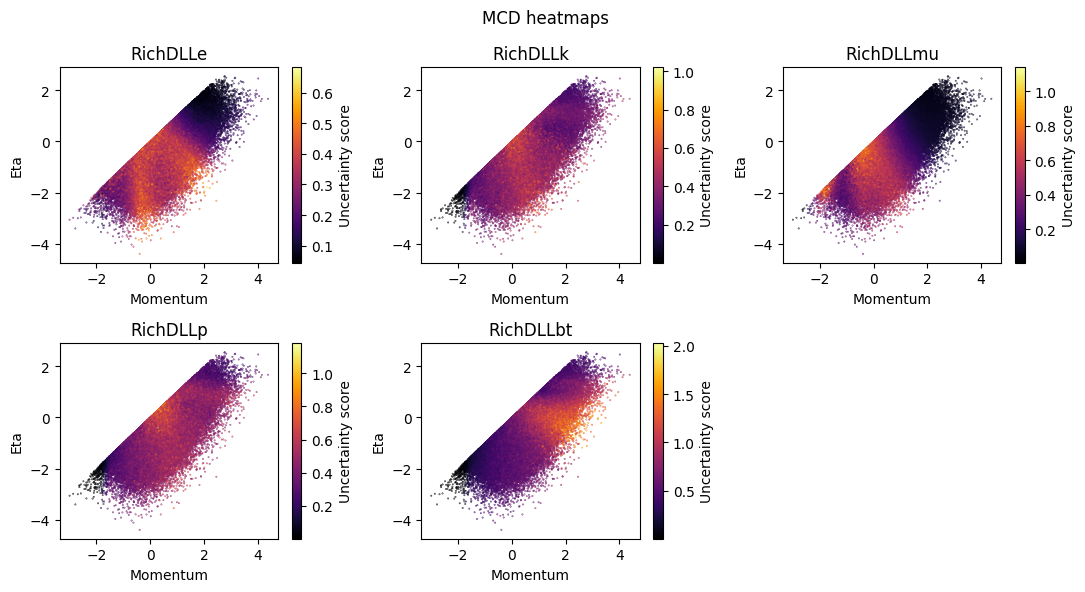

In [ ]:
uncertainty_scatter_plot_mcd(x_sample, mcd_uncertainty)

In [ ]:
def uncertainty_hist2d_mcd(x_real, uncertainties, n_bins=100):
  momentum = x_real[:, 0]
  eta = x_real[:, 1]

  fig, axes = plt.subplots(2, 3, figsize=(11, 6))

  for ax_index, ax in enumerate(axes.flatten()[:-1]):
    momentum_edges, eta_edges = np.histogram2d(momentum, eta, n_bins)[1:]
    momentum_indices = np.digitize(momentum, momentum_edges)
    eta_indices = np.digitize(eta, eta_edges)

    heatmap = []

    for i in range(1, n_bins + 1):
      row = []
      for j in range(1, n_bins + 1):
        row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]
      heatmap += [row]

    ax.set_title(DLL_COLUMNS[ax_index])
    image = ax.imshow(heatmap, 'inferno')
    ax.invert_yaxis()
    plt.colorbar(image, label='Uncertainty score')
    ax.set_xlabel('Momentum')
    ax.set_ylabel('Eta')

  plt.suptitle('MCD heatmaps')
  axes[-1, -1].axis(False)
  plt.tight_layout()
  plt.show()

<ipython-input-29-da10556d77ee>:17: RuntimeWarning: Mean of empty slice.
  row += [uncertainties[(momentum_indices == j) & (eta_indices == i), ax_index].mean()]


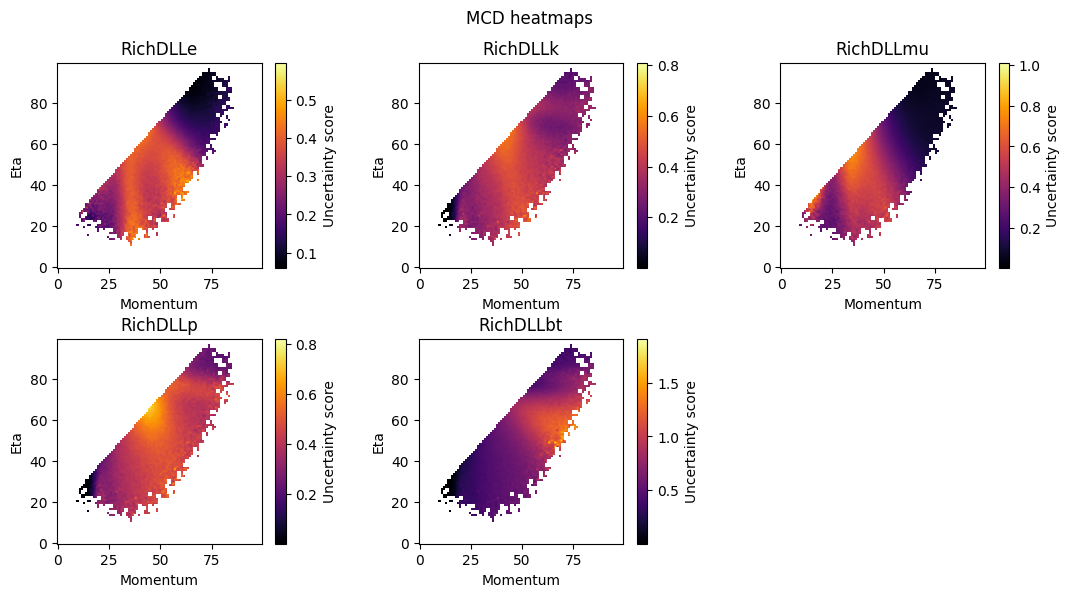

In [ ]:
uncertainty_hist2d_mcd(x_sample, mcd_uncertainty)

# Efficiency plots

In [ ]:
def select_threshold(feature, quantile=0.1):
    return np.quantile(feature, quantile)

def efficiency_bins(targets, threshold, particle_index):
    def compute_efficiency(y):
        return (y > threshold).mean()

    def compute_error(y):
        err = (y < threshold).sum() * (y > threshold).sum() / y.size**3
        return np.sqrt(err)

    efficiencies = []
    errors = []

    for target in targets:
        eff = compute_efficiency(target[:, particle_index])
        err = compute_error(target[:, particle_index])

        efficiencies.append(eff)
        errors.append(err)

    return efficiencies, errors

def compute_bin_indices(data, n_bins):
  bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
  indices = np.digitize(data, bin_edges)
  return indices

def plot_efficiencies(y_sample, t_generated, uncertainties, quantiles, n_bins=10, dll_columns=DLL_COLUMNS):
  y_sample = np.array(y_sample)
  t_generated = np.array(t_generated)
  uncertainties = np.array(uncertainties)

  fig, axes = plt.subplots(2, 3, figsize=(9, 6))

  indices = compute_bin_indices(uncertainties, n_bins)

  bins_targets = [t_generated[indices == i] for i in range(1, n_bins + 1)]
  bins_likelihoods = [uncertainties[indices == i].mean() for i in range(1, n_bins + 1)]

  for idx, ax in zip(range(5), axes.flatten()):
      for quantile in quantiles:
          threshold = select_threshold(y_sample[:, idx], quantile)
          eff, err = efficiency_bins(bins_targets, threshold, idx)

          plot = ax.plot(bins_likelihoods, eff, '.-', label=f'Quantile = {int(quantile * 100)}%')
          ax.errorbar(bins_likelihoods, eff, err, color=plot[0].get_color())

      ax.set_title(dll_columns[idx])
      ax.set_axisbelow(True)
      ax.grid()
      ax.set_xlabel("Bin likelihood")
      ax.set_ylabel("Efficiency")

  axes[-1, -1].axis(False)
  handles, labels = ax.get_legend_handles_labels()
  plt.legend(handles, labels, loc='upper left')

  plt.tight_layout()
  plt.show()

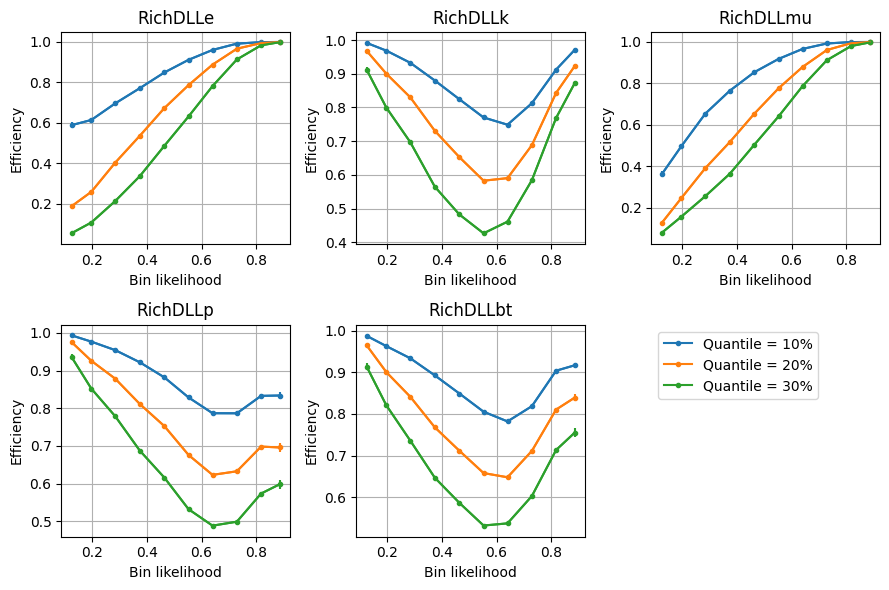

In [ ]:
plot_efficiencies(y_sample, t_generated, fd_uncertainty_normalized, [.1, .2, .3])

# Archived

#### FD with integration method


In [ ]:
fd_uncertainty_integration, _ = fd_evaluate_model(model, x_sample, known_embeddings=train_embeddings, n_fit_samples=100,
                                                  likelihood_method='integration')

print('Feature Densities using INTEGRATION uncertainty score for x_sample:')
fd_uncertainty_integration

Generating an embeddings model
Fitting KDE functions to known embeddings
Calculating sample's embeddings
3125/3125 [==============================] - 9s 3ms/step
Estimating sample's feature densities


100%|██████████| 100000/100000 [09:40<00:00, 172.17it/s]


Feature Densities using INTEGRATION uncertainty score for x_sample:


<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([0.99166736, 0.99320438, 0.98483132, ..., 0.98967961, 0.99608143,
       0.99588692])>

In [ ]:
# Save FD uncertainties with integration
np.save(output_dir + f'{PARTICLE}_fd_uncertainty_integration.npy', fd_uncertainty_integration)

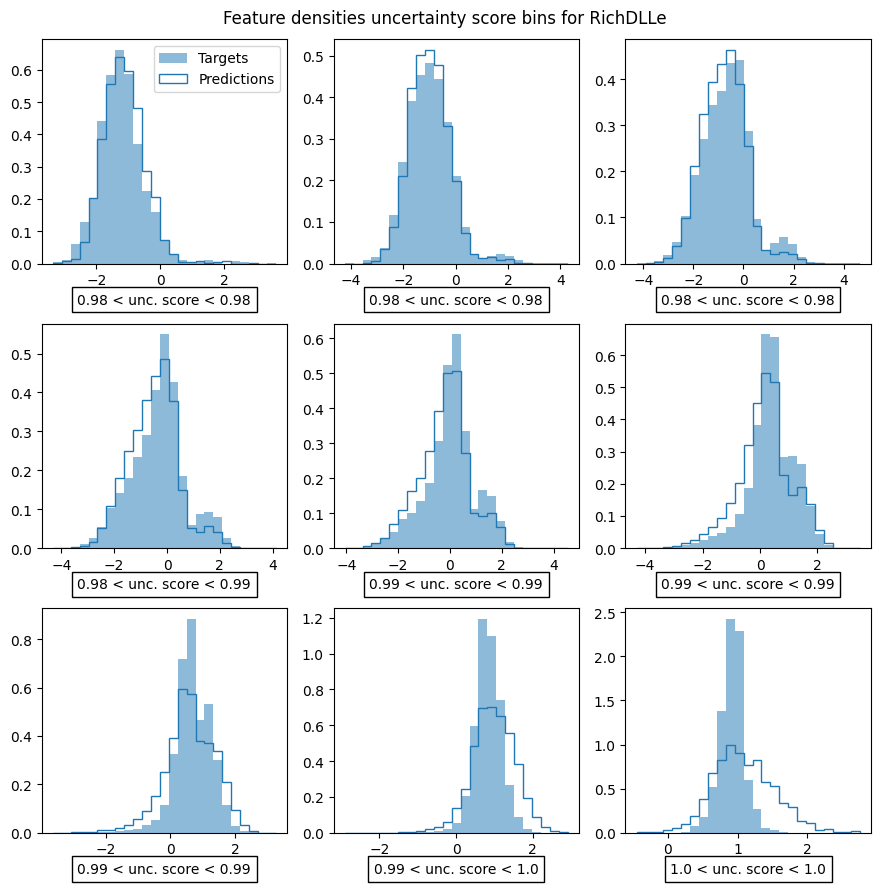

Jensen–Shannon distances:
0.09622084580538806, 0.0585183208196027, 0.07431106037785432, 0.09173176860875591, 0.09969241943001567, 0.1289956595370403, 0.1652380894043553, 0.23538475012621202, 0.37240579948854996


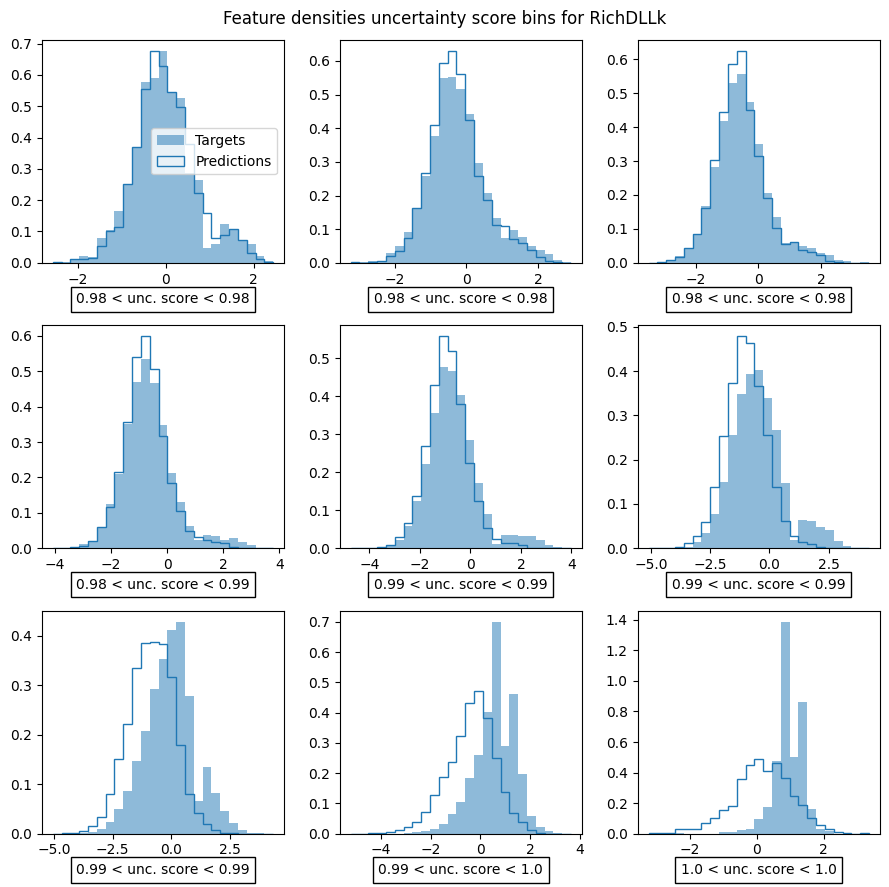

Jensen–Shannon distances:
0.08371077511448784, 0.0654720960520344, 0.05653954859424112, 0.08536574793440575, 0.12179464150396475, 0.19473439847731874, 0.27741588916878446, 0.36904235257402945, 0.4543678655925674


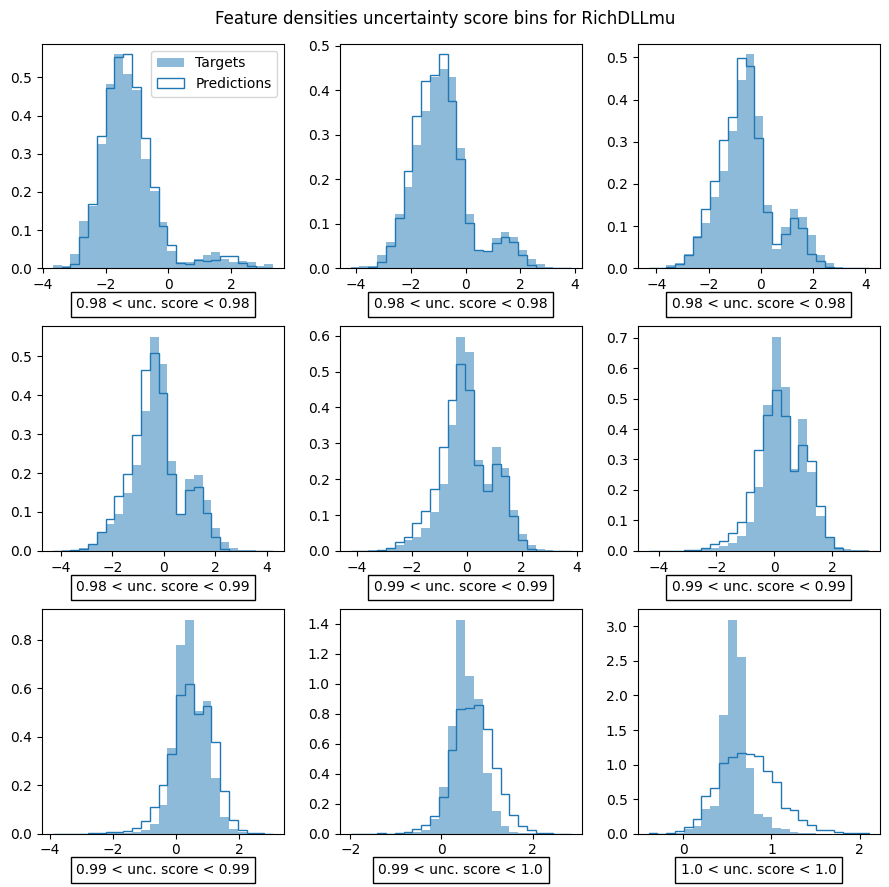

Jensen–Shannon distances:
0.08320841671858444, 0.06635888091019594, 0.08031478887903035, 0.08909623357918102, 0.09709237328152125, 0.11220610235831453, 0.14084113348506, 0.20008794857001014, 0.33758575031583343


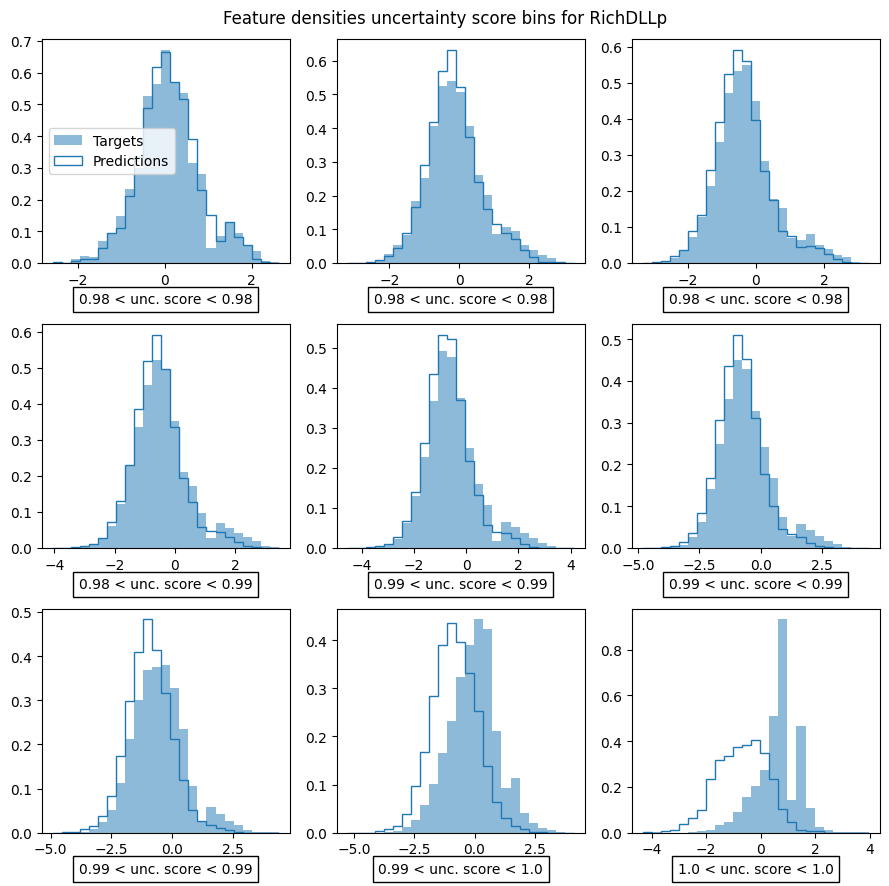

Jensen–Shannon distances:
0.07744682746742482, 0.06820153217264702, 0.07114998976382521, 0.08848384543658083, 0.09976903628186125, 0.1156986940602862, 0.15394968716591595, 0.28277369434794486, 0.49574636685905726


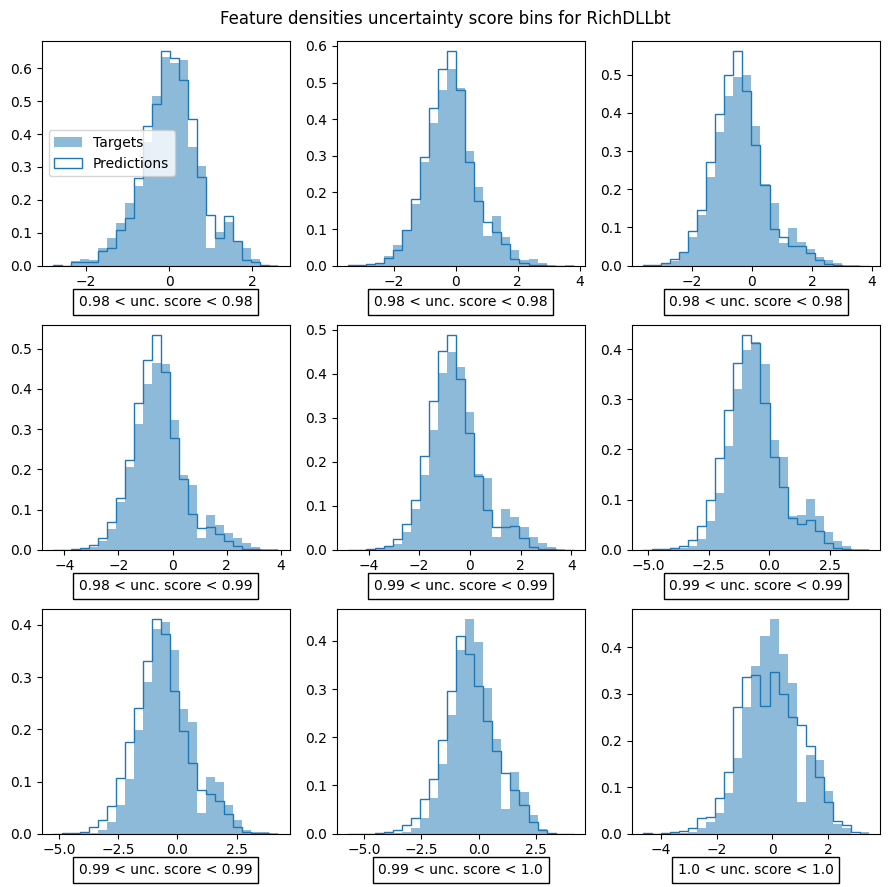

Jensen–Shannon distances:
0.08230790301719008, 0.07236818519397839, 0.07654665836042317, 0.09328260423021431, 0.104209952407771, 0.11565582126353942, 0.12169049182965685, 0.11879987567474574, 0.14639536458260857


In [ ]:
all_fd_bin_edges, all_fd_js_distances = [], []

for i in range(5):
  fd_bin_edges, fd_js_distances = estimate_distances_and_plot_uncertainty_bins(
      y_sample, t_generated, fd_uncertainty_integration, 'Feature densities', particle_index = i, n_rows = 3, n_cols = 3)

  all_fd_bin_edges += [fd_bin_edges]
  all_fd_js_distances += [fd_js_distances]

Correlation coefficient for RichDLLe: 0.845066837334593
Correlation coefficient for RichDLLk: 0.9224163337708419
Correlation coefficient for RichDLLmu: 0.825405229820007
Correlation coefficient for RichDLLp: 0.8058483879419905
Correlation coefficient for RichDLLbt: 0.9469326100625362


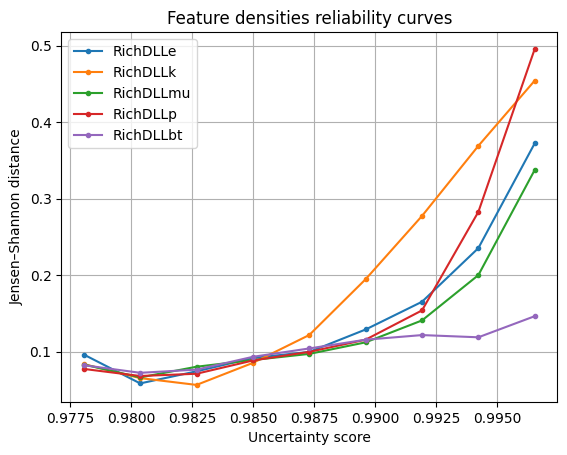

In [ ]:
plot_all_distances(all_fd_bin_edges, all_fd_js_distances, 'Feature densities')

### Generation of FD embeddings

In [ ]:
from feature_densities.feature_density_evaluator import create_embeddings_model
embeddings_model = create_embeddings_model(model)

In [ ]:
train_embeddings, train_predictions = embeddings_model.predict(dataset['feats_train'])

29641/29641 [==============================] - 84s 3ms/step


In [ ]:
test_embeddings, test_predictions = embeddings_model.predict(dataset['feats_val'])

16428/16428 [==============================] - 43s 3ms/step


In [ ]:
!rm -r embeddings
!mkdir embeddings

np.save(embeddings_dir + f'{PARTICLE}_train_embeddings.npy', train_embeddings)
np.save(embeddings_dir + f'{PARTICLE}_train_predictions.npy', train_predictions)
np.save(embeddings_dir + f'{PARTICLE}_test_embeddings.npy', test_embeddings)
np.save(embeddings_dir + f'{PARTICLE}_test_predictions.npy', test_predictions)